<a href="https://colab.research.google.com/github/nataliasiennicka/Air-pollution-forecast-for-Krakow-districts/blob/main/Prognoza%20zanieczyszczenia%20powietrza%20dla%20dzielnic%20Krakowa%20-%20projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Połączenie z dyskiem

In [69]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [70]:
#  os.chdir('drive/MyDrive/Colab Notebooks/Projekt końcowy')

# PROBLEM -----> PROGNOZA ZANIECZYSZCZENIA POWIETRZA DLA KAŻDEJ Z DZIELNIC KRAKOWA

Obecnie jest rok 2017 (dane z kaggle). W kolejnym roku miasto Kraków chce zaofereować mieszkańcom serie letnich wydarzeń kulturalnych w plenerze (kina nocne, koncerty, plenerowe teatry, pikniki, itp.) w ramach akcji "Lato w mieście" (link do aktualnego wydarzenia: https://www.krakow.pl/201352,artykul,lato.html). 

Dużym problemem miasta jest jego zanieczyszczenie, które często przekracza normy wskaźników zanieczyszczeń ustalone przez WHO. Przy planowanych imprezach plenrowych jakość powietrza jest istotana, aby nie narażać bezpieczeństwa ludzi. Miasto planuje zorganizować ciąg wydarzeń od 01 czerwca 2018 do 31 sierpnia 2018. Problem polega na wyborze dzielnicy Krakowa, w której takie wydarzenia mogłyby się odbywać.




Dane:
  - zbiór plików csv, które dotyczą danych pogodowych :temberatura, wilgotność, ciśnienie oraz wskaźniki zanieczyszczenia

  - współrzedne punktów czujników pomiarowych na których dane były zbierane

Dodatkowe informacje:
  - wskaźnik PM1 jest nieskalibrowany i dlatego może być większy niż PM25
  - przez pierwsze 2 miesiące wilgotność i temperatura nie były skalibrowane



#Importy

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import glob
import folium
import plotly.express as px
import plotly.graph_objs as go

In [72]:
from sklearn import tree #do wyplotowania wykresu drzewa decyzyjnego

#Tworzenie modeli
from sklearn.model_selection import GridSearchCV #sprawdzanie kombinacji parametrów
from sklearn.tree import DecisionTreeRegressor #model drzewa decyzyjnego
from sklearn.ensemble import RandomForestRegressor #model random forest dla problemu reresji
from sklearn.preprocessing import StandardScaler #do standaryzacji danych
from sklearn.linear_model import LinearRegression #model regresji liniowej
from sklearn.preprocessing import PolynomialFeatures #model wielomianu
from sklearn.pipeline import make_pipeline #tworzenie przepływu danych i uczenia modelu na nich
from sklearn.model_selection import GridSearchCV #sprawdzanie kombinacji parametrów
from sklearn.model_selection import TimeSeriesSplit #do CV dla szeregów czasowych

#Ocena modeli:
from sklearn.dummy import DummyRegressor #do porównania modeli
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from math import sqrt





#Funkcje

In [73]:
#funkcja uzupełniająca wartości tabeli wartością średnią wiersza
def refill_null_value(df):
  df_t = df.T
  for date in df_t.columns:
    df_t[date].fillna(np.mean(df_t[date]), inplace=True)
  
  df = df_t.T

#Plot do wykresów pudełkowych
def plot_boxplot(df):
  fig, ax = plt.subplots(figsize=(30, 10))
  ax = sns.boxplot(data=df, palette='Set3')
  _ = plt.title(f"Wykres rozkładu cechy dla każdego z czujników", fontsize =16)
  _ = plt.xlabel("Sensor")
  _ = plt.yticks(fontsize=16)
  _ = plt.xticks(fontsize=10,rotation = 45)
  _ = plt.show()
  _ =plt.savefig('plot.jpg')


In [74]:
#Funkcje do zmiany nazw w listach

def rename_sensor(list, parametr):
  for i in range(len(list)):
    list[i]=list[i]+parametr

def rename_each_district_with_parametr(list_of_district,parametr1):
  for dis in list_of_district:
    rename_sensor(dis,parametr1)

def create_new_table(table, name_of_new_value): 
  table[name_of_new_value]=table.mean(axis=1) 
  table = table.loc[:,[name_of_new_value]]
  return table

#funkcja -> wszystkie dzielnice dla parametru
def change_colfor_districts(par1,table1):
  s_II = ['3', '140' ,'196' ,'201']
  s_VI = ['142' ,'170' ,'172' ,'895']
  s_XIII = ['147' ,'176' ,'227' ,'622' ,'857']
  s_XVIII = ['169', '194']
  s_III = ['171']
  s_VII = ['173' ,'174', '192', '212' ,'218']
  s_IV = ['177' ,'183', '185', '187', '205', '208' ,'209' ,'808']
  s_VIII = ['184' ,'216' ,'222' ,'225' ,'713']
  s_V = ['179', '213']
  s_XII = ['180' ,'182']
  s_I = ['181', '189', '204', '214' ,'220']
  s_XIV = ['195' ,'210', '221']
  s_X = ['202' ,'226']
  s_XVII = ['219']
  s_XV = ['215']
  s_IX = ['223' ,'228']
  s_XI = ['263']

  list_of_district = [s_II,s_VI,s_XIII,s_XVIII,s_III,s_VII,s_IV,s_VIII,s_V,s_XII,s_I,s_XIV,s_X,s_XVII,s_XV,s_IX,s_XI]

  rename_each_district_with_parametr(list_of_district,par1)

  s_II = table1.loc[:,s_II]
  s_VI = table1.loc[:,s_VI]
  s_XIII= table1.loc[:,s_XIII]
  s_XVIII = table1.loc[:,s_XVIII]
  s_III = table1.loc[:,s_III]
  s_VII = table1.loc[:,s_VII]
  s_IV = table1.loc[:,s_IV]
  s_VIII = table1.loc[:,s_VIII]
  s_V = table1.loc[:,s_V]
  s_XII = table1.loc[:,s_XII]
  s_I = table1.loc[:,s_I]
  s_XIV = table1.loc[:,s_XIV]
  s_X = table1.loc[:,s_X]
  s_XVII = table1.loc[:,s_XVII]
  s_XV = table1.loc[:,s_XV]
  s_IX = table1.loc[:,s_IX]
  s_XI = table1.loc[:,s_XI]

  s_II = create_new_table(s_II, f"s_II{par1}")
  s_VI = create_new_table(s_VI, f"s_VI{par1}")
  s_XIII= create_new_table(s_XIII, f"s_XIII{par1}")
  s_XVIII = create_new_table(s_XVIII, f"s_XVIII{par1}")
  s_III = create_new_table(s_III, f"s_III{par1}")
  s_VII = create_new_table(s_VII, f"s_VII{par1}")
  s_IV = create_new_table(s_IV, f"s_IV{par1}")
  s_VIII = create_new_table(s_VIII, f"s_VIII{par1}")
  s_V = create_new_table(s_V, f"s_V{par1}")
  s_XII = create_new_table(s_XII, f"s_XII{par1}")
  s_I = create_new_table(s_I, f"s_I{par1}")
  s_XIV = create_new_table(s_XIV, f"s_XIV{par1}")
  s_X = create_new_table(s_X, f"s_X{par1}")
  s_XVII = create_new_table(s_XVII, f"s_XVII{par1}")
  s_XV = create_new_table(s_XV, f"s_XV{par1}")
  s_IX = create_new_table(s_IX, f"s_IX{par1}")
  s_XI = create_new_table(s_XI, f"s_XI{par1}")

  s_I=pd.concat([s_I,s_II],axis=1)
  s_I=pd.concat((s_I,s_III),axis=1)
  s_I=pd.concat((s_I,s_IV),axis=1)
  s_I=pd.concat((s_I,s_V),axis=1)
  s_I=pd.concat((s_I,s_VI),axis=1)
  s_I=pd.concat((s_I,s_VII),axis=1)
  s_I=pd.concat((s_I,s_VIII),axis=1)
  s_I=pd.concat((s_I,s_IX),axis=1)
  s_I=pd.concat((s_I,s_X),axis=1)
  s_I=pd.concat((s_I,s_XI),axis=1)
  s_I=pd.concat((s_I,s_XII),axis=1)
  s_I=pd.concat((s_I,s_XIII),axis=1)
  s_I=pd.concat((s_I,s_XIV),axis=1)
  s_I=pd.concat((s_I,s_XV),axis=1)
  s_I=pd.concat((s_I,s_XVII),axis=1)
  s_I=pd.concat((s_I,s_XVIII),axis=1)
  return s_I
  

In [75]:
#Korelogram
def print_corelogram(X,size):
  plt.figure(figsize=size)
  ax = sns.heatmap(X.corr(), vmin=-1, vmax=1,
                  xticklabels=X.corr().columns, 
                  yticklabels=X.corr().columns, 
                  cmap='bwr', 
                  center=0, 
                  annot=True)

  plt.title('Correlogram of data', fontsize=22)
  bottom, top = ax.get_ylim()
  ax.set_ylim(bottom + 0.5, top - 0.5)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.show()

In [76]:
#FUNKCJA OCENY MODELI
metrics_dataframe = pd.DataFrame(columns = ['Model', 'R2', 'MAE_train','MAE_test','MAPE_train [%]','MAPE_test [%]','RMSE_train','RMSE_test'])

def calculate_metrics(name,y_train,y_test,y_train_pred, y_test_pred):
  global metrics_dataframe #funkcja wie, że koćysta ze zmiennej lokalnej
  r2 = r2_score(y_train, y_train_pred)

  MAE_train = mean_absolute_error(y_train, y_train_pred)
  MAE_test = mean_absolute_error(y_test, y_test_pred)

  MAPE_train = mean_absolute_percentage_error(y_train,y_train_pred)*100
  MAPE_test = mean_absolute_percentage_error(y_test,y_test_pred)*100

  mse_train = mean_squared_error(y_train, y_train_pred)
  mse_test = mean_squared_error(y_test, y_test_pred)
  rmse_train =sqrt(mse_train)
  rmse_test =sqrt(mse_test)

  metrics_dataframe=metrics_dataframe.append({'Model': name,'R2': r2,'MAE_train': MAE_train,'MAE_test': MAE_test,'MAPE_train [%]': MAPE_train,'MAPE_test [%]': MAPE_test,'RMSE_train': rmse_train,'RMSE_test': rmse_test},
                                                 ignore_index=True)
  return metrics_dataframe


In [77]:
def plot_evaluation(y_predict,y_test):
  # Porównanie wartości prawdziwej z predykcją
  plt.figure(figsize=(14,9))
  plt.scatter(x = y_predict, y = y_test, alpha=0.25, color='green')

  xmin, xmax = y_test.min(), y_test.max()
  x_line = np.linspace(xmin, xmax, 10)
  y_line = x_line

  # Oczekiwana linia trendu
  plt.plot(x_line, y_line, 'r--')

  plt.xlabel('Prediction', fontsize=16)
  plt.ylabel('True value', fontsize=16)
  plt.title('Porównanie wartości prawdziwej z predykcją', fontsize=20)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.show()

  # Wykres reszt
  plt.figure(figsize=(14,9))
  errors = y_predict - y_test
  plt.scatter(x = y_test, y=errors, alpha = 0.25)
  plt.axhline(0,color = 'red', linestyle='--')
  plt.xlabel('True values', fontsize=16)
  plt.ylabel('Residuals', fontsize=16)
  plt.title('Wykres reszt', fontsize=20)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.show()

  #Histogram reszt

  plt.figure(figsize=(14,9))
  print(f'Średni błąd: {errors.mean()}')
  plt.hist(errors, bins=20)
  plt.axvline(errors.mean(), color='black', linestyle='dashed', linewidth=1)
  plt.title('Histogram reszt', fontsize=20)

  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)

  plt.show()

#Wczytywanie danych

In [78]:
#wczytanie pojedynczych csv z każdego miesiąca
jan = pd.read_csv('january-2017.csv')
feb = pd.read_csv('february-2017.csv')
mar = pd.read_csv('march-2017.csv')
apr = pd.read_csv('april-2017.csv')
may = pd.read_csv('may-2017.csv')
jun = pd.read_csv('june-2017.csv')
jul = pd.read_csv('july-2017.csv')
aug = pd.read_csv('august-2017.csv')
sep = pd.read_csv('september-2017.csv')
oct = pd.read_csv('october-2017.csv')
nov = pd.read_csv('november-2017.csv')
dec = pd.read_csv('december-2017.csv')

#złączenie wszystkich tabel to jednego roku
yr_2017 = pd.concat([jan,	feb,	mar,	apr,	may,	jun,	jul,	aug,	sep,	oct,	nov,	dec])

#Wczytanie danych z lokalizacją stacji pomiarowych
sensors = pd.read_csv('sensor_locations.csv')

In [79]:
#Jakie są typy danych?
yr_2017.dtypes

UTC time          object
3_temperature    float64
3_humidity       float64
3_pressure       float64
3_pm1            float64
                  ...   
895_humidity     float64
895_pressure     float64
895_pm1          float64
895_pm25         float64
895_pm10         float64
Length: 337, dtype: object

In [80]:
# Czy są jeszcze inne typy poza floatem i object?
yr_2017.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

In [81]:
#Zamiana dat na typ datetime
yr_2017['UTC time'] =  pd.to_datetime(yr_2017['UTC time'])

# Rozmieszczenie punktów pomiarowych

In [82]:
sensors.head(3)

id   latitude  longitude dzielnica
0    3  50.057748  19.961375        II
1  140  50.057747  19.961374        II
2  142  50.084816  19.878066        VI

In [83]:
sensors['name']=sensors['id']
sensors['name']=sensors['name'].astype(str)
sensors.head(3)

id   latitude  longitude dzielnica name
0    3  50.057748  19.961375        II    3
1  140  50.057747  19.961374        II  140
2  142  50.084816  19.878066        VI  142

In [84]:
#instalacja biblioteki geopandas imożliwającej pracę z mapą
!pip install geopandas  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import geopandas 
my_map = folium.Map(
    location = [50.062006, 	19.940984], 
    width='90%', 
    height='80%',
    tiles='CartoDB Positron',
    zoom_start=11.5)

granica = f"/content/drive/MyDrive/Colab Notebooks/Projekt końcowy/shp/dzielnica.geojson"

borderStyle={
    'color':'green',
    'weight':3,
    'fillColor':'green',
    'fillOpacity' :0.05
}

folium.GeoJson(granica, name='dzielnica',
               style_function=lambda x:borderStyle).add_to(my_map)


for _, sensor in sensors.iterrows():

  folium.Marker(
      location=[sensor['latitude'],sensor['longitude']],
      popup=sensor['dzielnica']
                ).add_to(my_map)

my_map

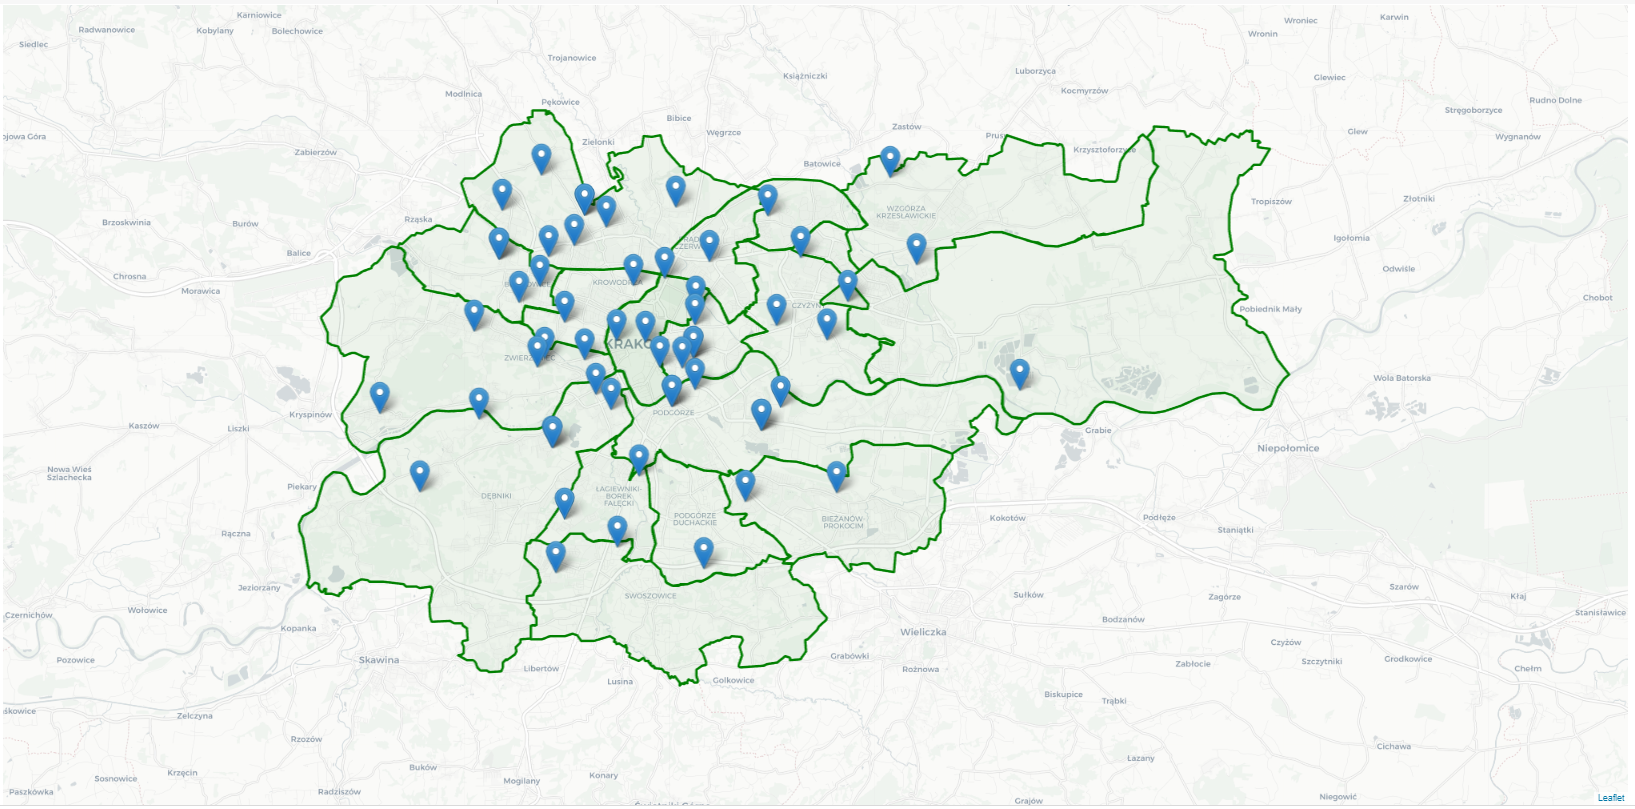

Na powyższej mapie utworzonej na podkładzie mapy google zaprezentowano rozmieszczenie czujników pomiarowych oraz przedstawiono poligony reprezentujące dzielnice Krakowa. Dzięki oknu z informacją dla danego markera istnieje możliwość bezpośredniego sprawdzenia w której dzielnicy znajduje się dany czujnik.

#Analiza cech

In [86]:
yr_2017.tail(5)

UTC time  3_temperature  3_humidity  3_pressure  3_pm1  3_pm25  \
572 2017-12-24 20:00:00            NaN         NaN         NaN    NaN     NaN   
573 2017-12-24 21:00:00            NaN         NaN         NaN    NaN     NaN   
574 2017-12-24 22:00:00            NaN         NaN         NaN    NaN     NaN   
575 2017-12-24 23:00:00            NaN         NaN         NaN    NaN     NaN   
576 2017-12-25 00:00:00            NaN         NaN         NaN    NaN     NaN   

     3_pm10  140_temperature  140_humidity  140_pressure  ...  857_pressure  \
572     NaN              6.0          87.0      101736.0  ...      101726.0   
573     NaN              6.0          88.0      101776.0  ...      101771.0   
574     NaN              6.0          85.0      101785.0  ...      101788.0   
575     NaN              5.0          88.0      101782.0  ...      101774.0   
576     NaN              6.0          88.0      101784.0  ...      101774.0   

     857_pm1  857_pm25  857_pm10  895_temperature  895_humidity  895_pressure  \
572     12.0      15.0      31.0              5.0          85.0      101798.0   
573     12.0      14.0      29.0              5.0          85.0      101840.0   
574     10.0      12.0      26.0              5.0          82.0      101839.0   
575      9.0      11.0      24.0              5.0          85.0      101837.0   
576     10.0      11.0      23.0              5.0          85.0      101840.0   

     895_pm1  895_pm25  895_pm10  
572     13.0      15.0      26.0  
573     12.0      13.0      23.0  
574     10.0      12.0      21.0  
575     10.0      12.0      21.0  
576     10.0      11.0      20.0  

[5 rows x 337 columns]

W związku z tym, że przez pierwsze 2 miesiące czytniki nie były skalibrowane, ze zbioru danych wyrzucono dane od 1.01.2017 do 28.02.2017

In [87]:
#Wybór danych poprzez datę
date_mask = (yr_2017['UTC time'] > '2017-02-28 23:00:00')
yr_2017 = yr_2017.loc[date_mask]

In [88]:
#Do ułatwienia sobie pracy z danymi oraz ich wizualizacji, zostały podzielone na pojedyncze tablice: temp, humi, pres, pm25, pm10, pm1 

temp_col = [col for col in yr_2017 if 'temperature' in col or col.startswith('UTC time')]
humi_col = [col for col in yr_2017 if 'humidity' in col or col.startswith('UTC time')]
pres_col = [col for col in yr_2017 if 'pressure' in col or col.startswith('UTC time')]
pm25_col = [col for col in yr_2017 if 'pm25' in col or col.startswith('UTC time')]
pm10_col = [col for col in yr_2017 if 'pm10' in col or col.startswith('UTC time')]
pm1_col = [col for col in yr_2017 if col.endswith('pm1') or col.startswith('UTC time')]

temp_col=yr_2017.filter(items=temp_col)
temp_col=temp_col.set_index('UTC time')
humi_col=yr_2017.filter(items=humi_col)
humi_col=humi_col.set_index('UTC time')
pres_col=yr_2017.filter(items=pres_col)
pres_col=pres_col.set_index('UTC time')
pm25_col=yr_2017.filter(items=pm25_col)
pm25_col=pm25_col.set_index('UTC time')
pm10_col=yr_2017.filter(items=pm10_col)
pm10_col=pm10_col.set_index('UTC time')
pm1_col=yr_2017.filter(items=pm1_col)
pm1_col=pm1_col.set_index('UTC time')


##Temperatura

Pierwszym parametrem dla którego sprawdzono wartości jest temperatura. Przyjmujemy, że na tym obszarze temperatura może wahać się od -20 do 40 stopni w ciagu roku.

In [89]:
temp_col.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7177 entries, 2017-03-01 00:00:00 to 2017-12-25 00:00:00
Data columns (total 56 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   3_temperature    0 non-null      float64
 1   140_temperature  6506 non-null   float64
 2   142_temperature  712 non-null    float64
 3   147_temperature  886 non-null    float64
 4   169_temperature  6958 non-null   float64
 5   170_temperature  7044 non-null   float64
 6   171_temperature  7105 non-null   float64
 7   172_temperature  1596 non-null   float64
 8   173_temperature  6985 non-null   float64
 9   174_temperature  5975 non-null   float64
 10  176_temperature  7129 non-null   float64
 11  177_temperature  6391 non-null   float64
 12  178_temperature  1302 non-null   float64
 13  179_temperature  7120 non-null   float64
 14  180_temperature  7169 non-null   float64
 15  181_temperature  7139 non-null   float64
 16  182_temperature  6144 no

Po uzyskaniu podstawowych informacji o zbiorze widać, że występują brakujące wartości w niektórych sensorach. Sprawdźmy jak rozkład tych wartości przedstawiony jest na wykresie.

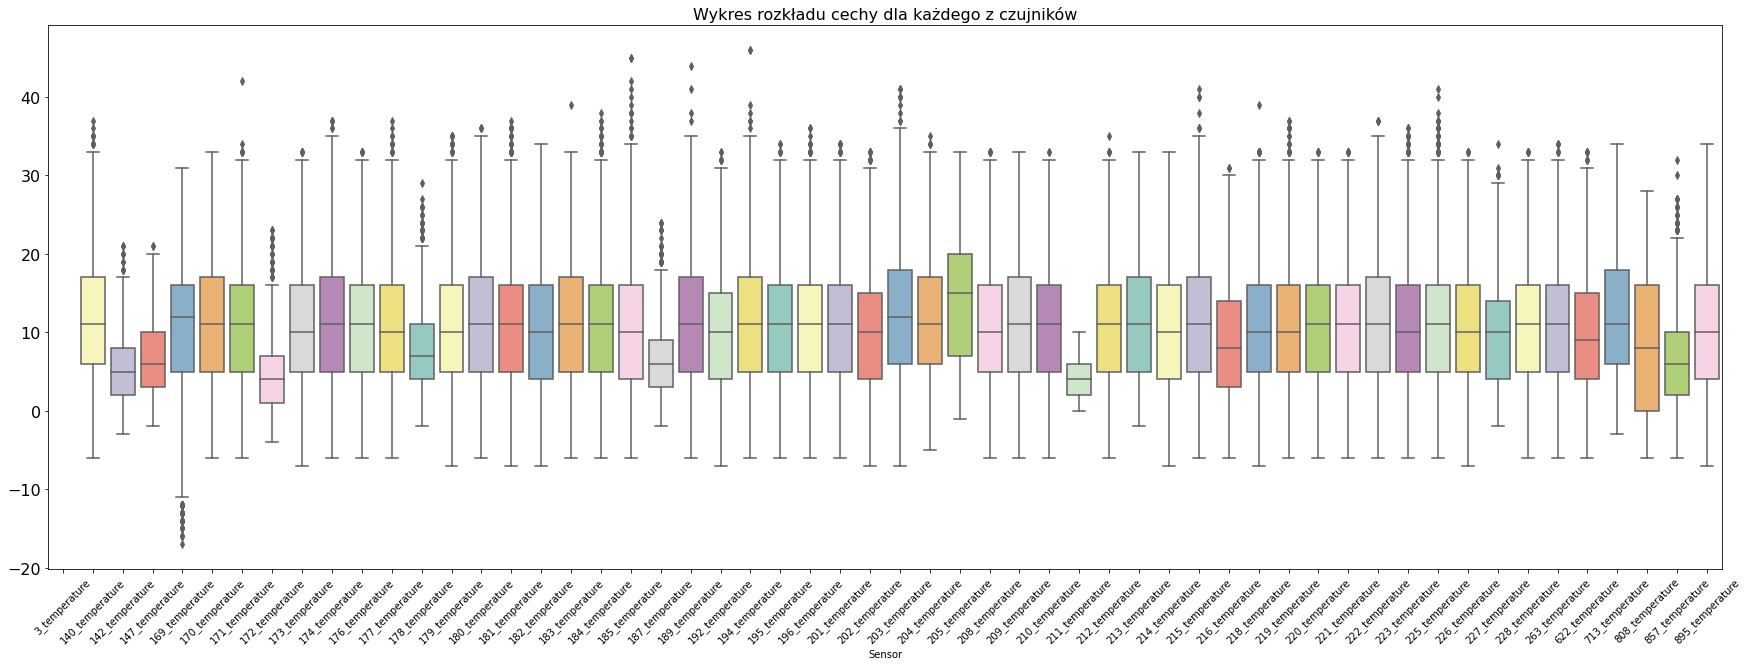

<Figure size 432x288 with 0 Axes>

In [90]:
plot_boxplot(temp_col)

Nie zaobserwowano dużych błędów wynikających z błędów w pomiarze np. temperatury spoza przewidywanego zakresu. Widać jednak, że dla sensora 169 odnotowywane są niższe wartości niż dla pozostałych, natomiast dla 185, 194, 215 i 225 występują wysokie wartości. Być może te sensory są szczególnie narażone na działanie tamperatury. 

Wartości nullowe występujące w zbiorze zostały zastąpione wartością średnią z pozostałych sensorów dla danej godziny.

In [91]:
#Wartości Nullowe zostały zastąpione średnią wartością temperatury z danego dnia
refill_null_value(temp_col)


Po uzupełnieniu wartości nullowych sprawdzamy jak wygląda wykres reprezentujący zakresy temperatur dla poszczególnych czujników.

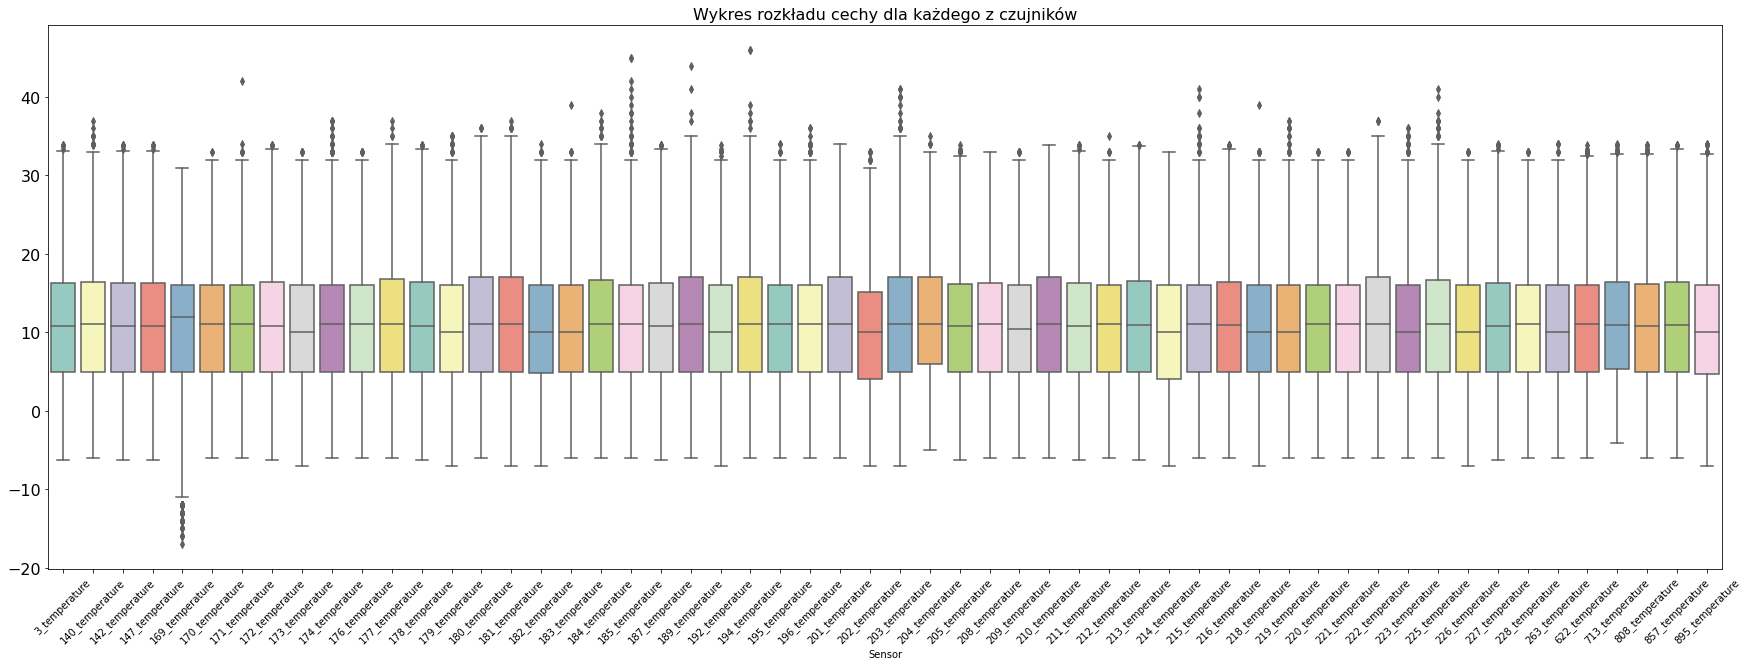

<Figure size 432x288 with 0 Axes>

In [92]:
plot_boxplot(temp_col)

Na wykresie natomiast widać, że temperatura dla każdego z sensorów ma podobny rozkład, co osnacza, że nie ma "grubych" błędów w pomiarach, istnieją natomiast wartości nullowe, które należałoby uzupełnić

##Wilgotność

Z założenia wilgotność powietrza wyznaczana jest w procentach, więc powinna przyjmować wartości od 0 do 100.

In [93]:
humi_col.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7177 entries, 2017-03-01 00:00:00 to 2017-12-25 00:00:00
Data columns (total 56 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   3_humidity    0 non-null      float64
 1   140_humidity  6506 non-null   float64
 2   142_humidity  712 non-null    float64
 3   147_humidity  886 non-null    float64
 4   169_humidity  6958 non-null   float64
 5   170_humidity  7044 non-null   float64
 6   171_humidity  7105 non-null   float64
 7   172_humidity  1596 non-null   float64
 8   173_humidity  6985 non-null   float64
 9   174_humidity  5975 non-null   float64
 10  176_humidity  7129 non-null   float64
 11  177_humidity  6391 non-null   float64
 12  178_humidity  1302 non-null   float64
 13  179_humidity  7120 non-null   float64
 14  180_humidity  7169 non-null   float64
 15  181_humidity  7139 non-null   float64
 16  182_humidity  6144 non-null   float64
 17  183_humidity  6708 non-null   float

Tutaj również występują braki w danych. Dodatkowo podobnie jak w przypadku temperatury dla sensora 211 występuje bardzo mało obserwacji. Prawdopodobnie czujnik był niesprawny. Spójrzmy jak wygląda zakres wartości na każdym sensorze:

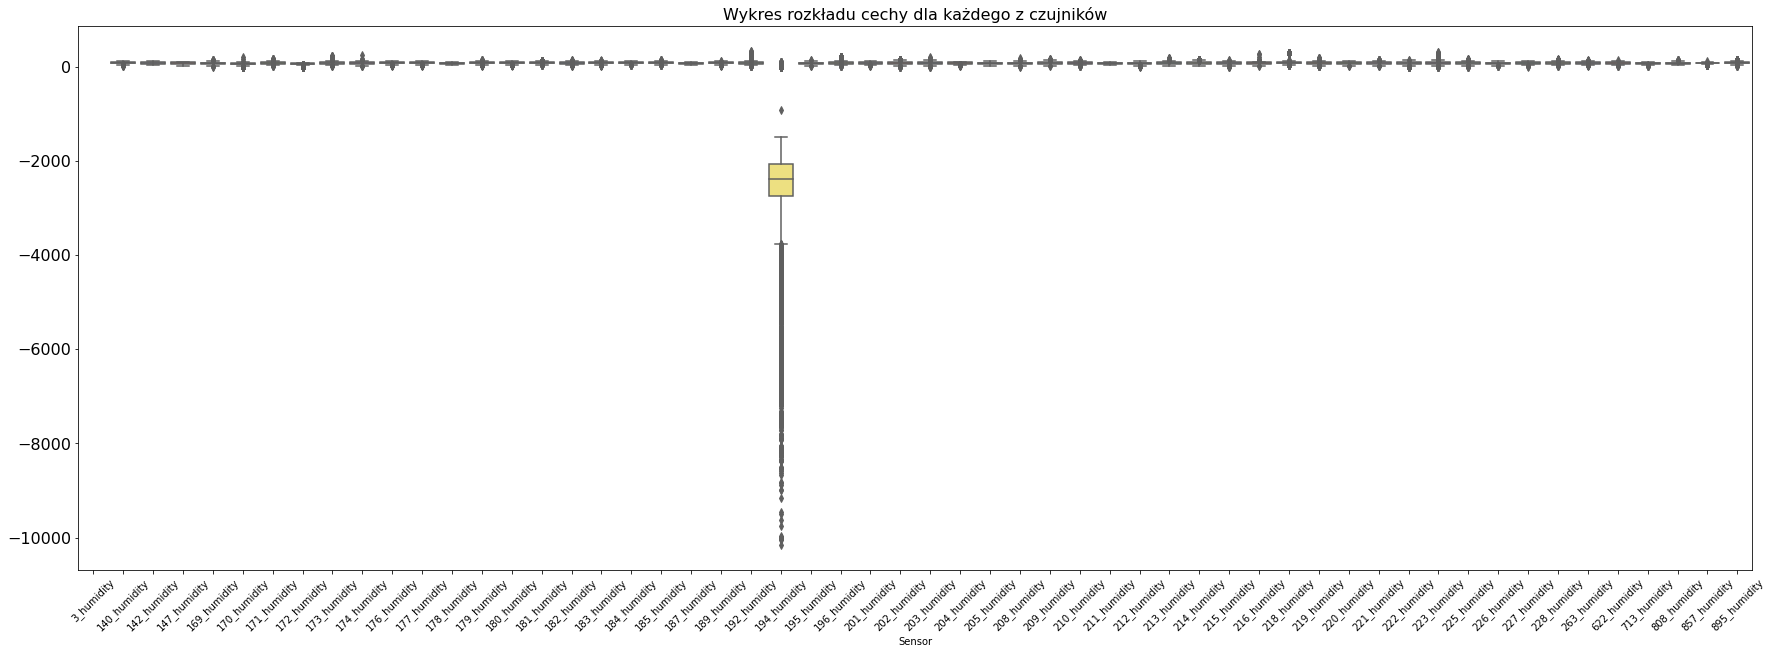

<Figure size 432x288 with 0 Axes>

In [94]:
plot_boxplot(humi_col)

Na przykładzie wykresu widać, że znaczący wpływ na dane mają występujące błędy dla sensora 194 wynikające z błędnych obserwacji poniżej 0.

In [95]:
humi_col_without_194 = humi_col.drop(columns="194_humidity")
min_194 = min(humi_col["194_humidity"])
max_194 = max(humi_col["194_humidity"])

In [96]:
print(f"Maksymalna wartość wilgotności dla sensora 194: {max_194}")
print(f"Minimalna wartość wilgotności dla sensora 194: {min_194}")
print()
print(f"Maksymalna wartość wilgotności bez sensora 194: {humi_col_without_194.max().max()}")
print(f"Minimalna wartość wilgotności bez sensora 194: {humi_col_without_194.min().min()}")

Maksymalna wartość wilgotności dla sensora 194: 94.0
Minimalna wartość wilgotności dla sensora 194: -10157.0

Maksymalna wartość wilgotności bez sensora 194: 337.0
Minimalna wartość wilgotności bez sensora 194: 1.0


Wartości znacząco przekracają założony zakres danych. Prawdopodobnie wystąpiły duże błędy na sensorze, dlatego należy usunać do z danych, gdyż nie jest możliwe stwierdzić, które z wartości są nieprawdziwe, a które prawidowe.

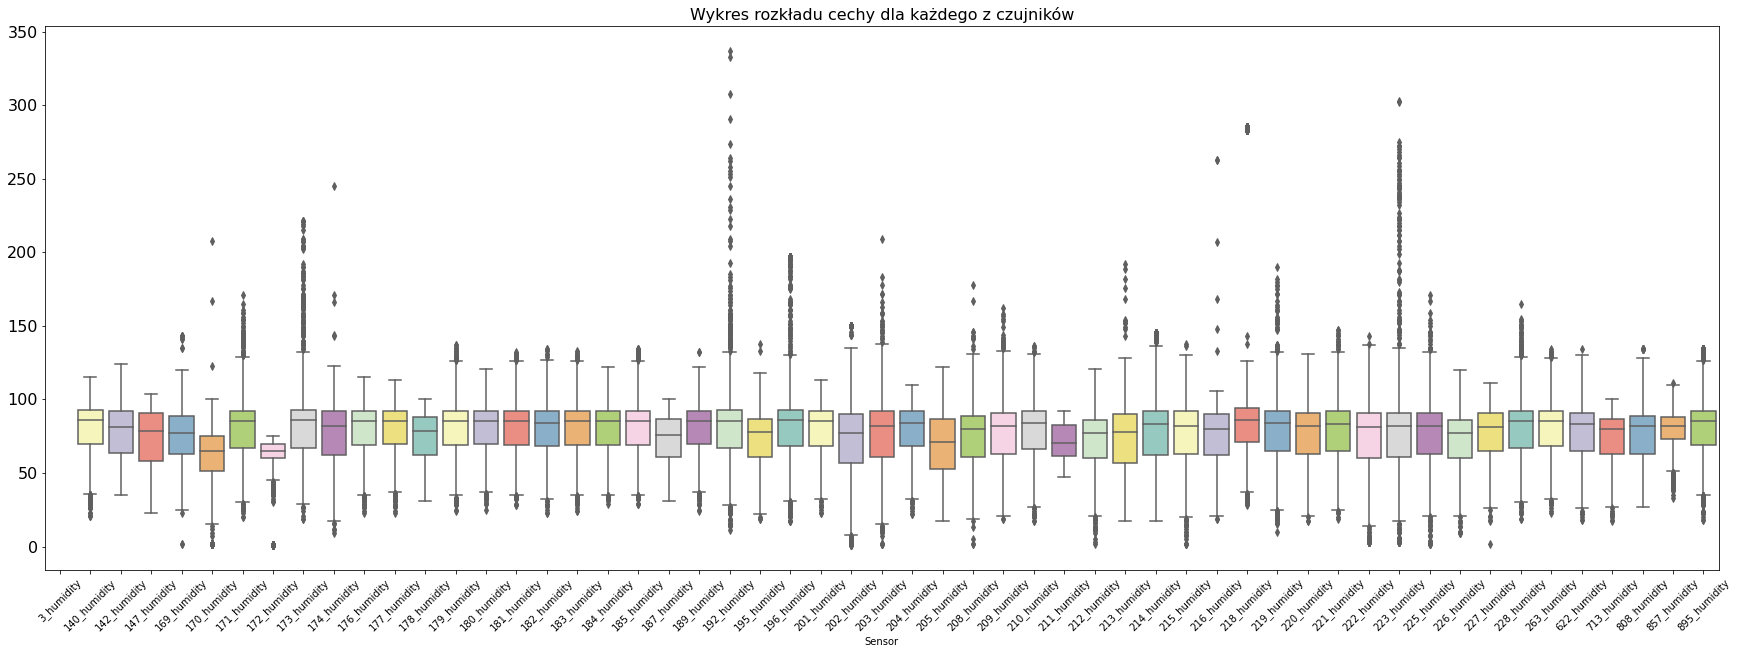

<Figure size 432x288 with 0 Axes>

In [97]:
plot_boxplot(humi_col_without_194)

Po usunięciu sensora 194 na pozostałych również pojawiły się błędne odczyty przekraczające 100%. Zastosowano odseparowanie tych wartości i ich zamiana na wartości Nullowe, które w kolejnym kroku, podobnie jak w przypadku temperatury zostaną zastąpione wartościami średnimi dla poszczególnych dni.

In [98]:
list_of_sensors = ['3_humidity', '140_humidity', '142_humidity', '147_humidity',
       '169_humidity', '170_humidity', '171_humidity', '172_humidity',
       '173_humidity', '174_humidity', '176_humidity', '177_humidity',
       '179_humidity', '180_humidity', '181_humidity', '182_humidity',
       '183_humidity', '184_humidity', '185_humidity', '187_humidity',
       '189_humidity', '192_humidity', '194_humidity', '195_humidity',
       '196_humidity', '201_humidity', '202_humidity', '203_humidity',
       '204_humidity',
       '205_humidity', '208_humidity', '209_humidity', '210_humidity',
       '212_humidity', '213_humidity', '214_humidity', '215_humidity',
       '216_humidity', '218_humidity', '219_humidity', '220_humidity',
       '221_humidity', '222_humidity', '223_humidity', '225_humidity',
       '226_humidity', '227_humidity', '228_humidity', '263_humidity',
       '622_humidity', '713_humidity', '808_humidity', '857_humidity',
       '895_humidity']

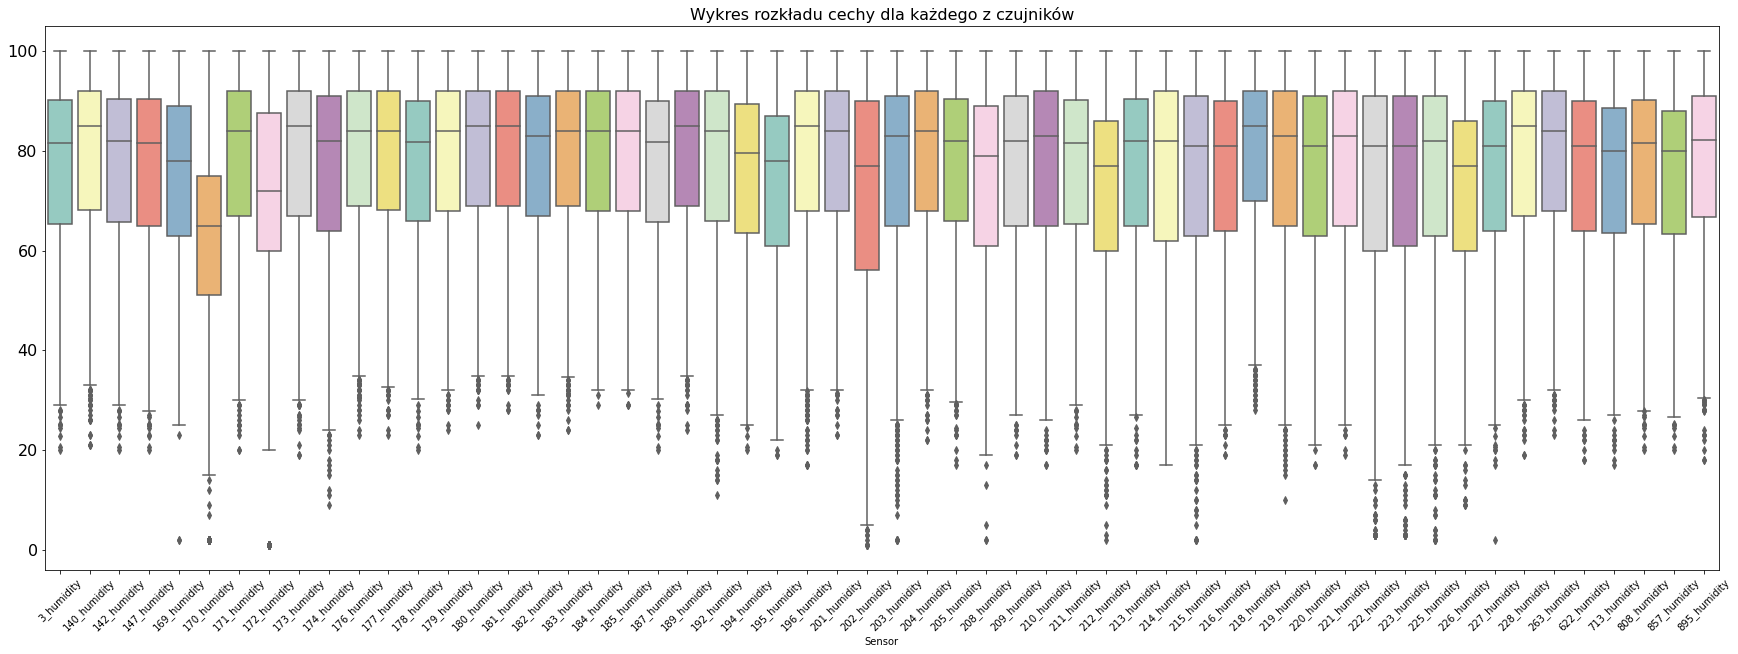

<Figure size 432x288 with 0 Axes>

In [99]:
#Wyrzucenie wartości spoza zakresu dla sensora 194
humi_col.loc[humi_col["194_humidity"]<=0,["194_humidity"]] = np.NaN

for sensor in list_of_sensors:
  humi_col.loc[humi_col[sensor]>100,[sensor]] = np.NaN
  
#Zastępienie wartości nullowych dla całej tablicy
refill_null_value(humi_col)

plot_boxplot(humi_col)

Powyższy wykres reprezentuje wartości wilgotności po wyczyszczeniu danych. Jak widać zakresy na każdym z czujników są zbliżone oraz nie przekraczają założonych przedziałów.

##Ciśnienie

In [100]:
pres_col.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7177 entries, 2017-03-01 00:00:00 to 2017-12-25 00:00:00
Data columns (total 56 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   3_pressure    229 non-null    float64
 1   140_pressure  6683 non-null   float64
 2   142_pressure  712 non-null    float64
 3   147_pressure  6550 non-null   float64
 4   169_pressure  6958 non-null   float64
 5   170_pressure  7044 non-null   float64
 6   171_pressure  7105 non-null   float64
 7   172_pressure  6984 non-null   float64
 8   173_pressure  7083 non-null   float64
 9   174_pressure  5975 non-null   float64
 10  176_pressure  1739 non-null   float64
 11  177_pressure  5548 non-null   float64
 12  178_pressure  0 non-null      float64
 13  179_pressure  1573 non-null   float64
 14  180_pressure  1738 non-null   float64
 15  181_pressure  1734 non-null   float64
 16  182_pressure  1701 non-null   float64
 17  183_pressure  954 non-null    float

Podobnie jak w poprzednich cechach występują braki w obserwacjach dla czujnika 211. Widać również, że 2 z sensorów nie podziadają danych pomiarowych dotyczących ciśnienia.

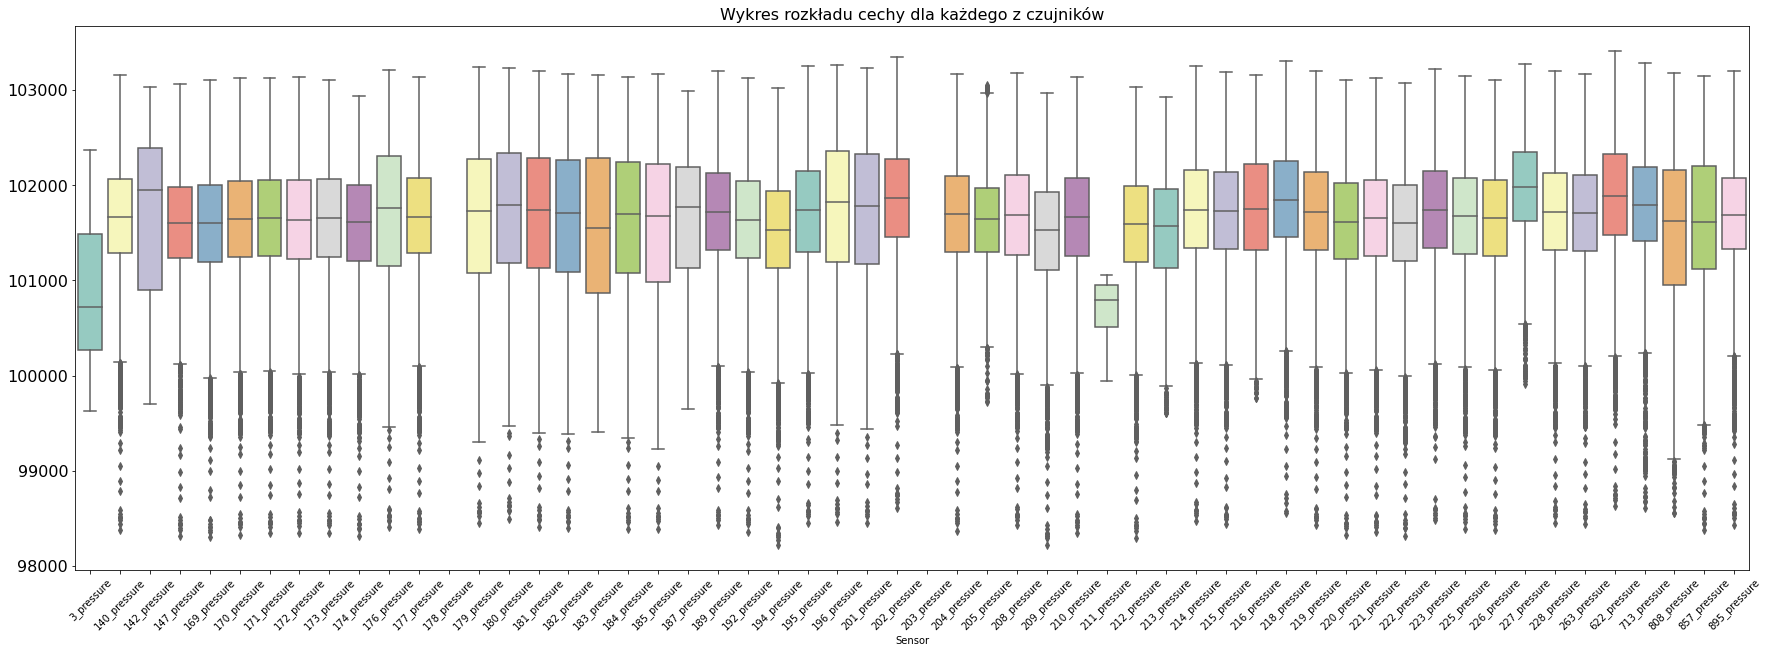

<Figure size 432x288 with 0 Axes>

In [101]:
plot_boxplot(pres_col)

Zakres danych z każdego sensora jest zbliżony, ne występują duże błędy w pomiarach, jadnak dla dwóch sensorów jest brak danych :203 oraz 178. Sprawdźmy zatem czy ich całkowite usunięcie nie spowoduje, że nie będzie reprezentacji dla którejś z dzielnic.


In [102]:
sensors.loc[(sensors['id']==203), :]

id   latitude  longitude dzielnica name
28  203  50.083454  20.057153      XVII  203

In [103]:
sensors.loc[(sensors['id']==178), :]

id   latitude  longitude dzielnica name
12  178  50.033195  19.900714      VIII  178

In [104]:
sensors.loc[(sensors['dzielnica']=='XVII'), :]

id   latitude  longitude dzielnica name
28  203  50.083454  20.057153      XVII  203
41  219  50.107347  20.045773      XVII  219

In [105]:
sensors.loc[(sensors['dzielnica']=='VIII'), :]

id   latitude  longitude dzielnica name
12  178  50.033195  19.900714      VIII  178
18  184  50.047736  19.919646      VIII  184
39  216  50.043527  19.925963      VIII  216
44  222  50.040717  19.869575      VIII  222
46  225  50.020756  19.844076      VIII  225
52  713  50.032902  19.900930      VIII  713

Zarówno w przypadku sensora 203 jak i 178 w dzielnicach w których są zlokalizowane, znajdują się inne czujniki. Zdecydowano, że pomiary z tych stanowisk zostaną odrzucone. Wartości Nullowe zostaną zastąpione wartościami średnimi

In [106]:
#Odrzucenie sensorów z tablic z danymi
pres_col.drop(columns=['178_pressure','203_pressure'],inplace=True)
humi_col.drop(columns=['178_humidity','203_humidity'],inplace=True)
temp_col.drop(columns=['178_temperature','203_temperature'],inplace=True)
pm25_col.drop(columns=['178_pm25','203_pm25'],inplace=True)
pm10_col.drop(columns=['178_pm10','203_pm10'],inplace=True)
pm1_col.drop(columns=['178_pm1','203_pm1'],inplace=True)
sensors.drop([12,28],axis=0,inplace=True)

In [107]:
#Uzupełnienie wartości nullowych wartością średnią z dnia
refill_null_value(pres_col)


##Wskaźniki PM25, PM10, PM1

Wskaźniki PM są reprezentacją ilości pyłów zawiedzonych w powietrzu w mikrogramach na m^3. Rozbite są na 3 kategorie, w zależności od średnicy drobin pyłu.

In [108]:
pm25_col.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7177 entries, 2017-03-01 00:00:00 to 2017-12-25 00:00:00
Data columns (total 54 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   3_pm25    229 non-null    float64
 1   140_pm25  6631 non-null   float64
 2   142_pm25  712 non-null    float64
 3   147_pm25  6550 non-null   float64
 4   169_pm25  6958 non-null   float64
 5   170_pm25  7044 non-null   float64
 6   171_pm25  7105 non-null   float64
 7   172_pm25  6984 non-null   float64
 8   173_pm25  7083 non-null   float64
 9   174_pm25  5975 non-null   float64
 10  176_pm25  7129 non-null   float64
 11  177_pm25  6391 non-null   float64
 12  179_pm25  7120 non-null   float64
 13  180_pm25  7169 non-null   float64
 14  181_pm25  7139 non-null   float64
 15  182_pm25  6150 non-null   float64
 16  183_pm25  6712 non-null   float64
 17  184_pm25  6974 non-null   float64
 18  185_pm25  6508 non-null   float64
 19  187_pm25  1075 non-null   float64

In [109]:
pm10_col.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7177 entries, 2017-03-01 00:00:00 to 2017-12-25 00:00:00
Data columns (total 54 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   3_pm10    229 non-null    float64
 1   140_pm10  6631 non-null   float64
 2   142_pm10  712 non-null    float64
 3   147_pm10  6550 non-null   float64
 4   169_pm10  6958 non-null   float64
 5   170_pm10  7044 non-null   float64
 6   171_pm10  7105 non-null   float64
 7   172_pm10  6984 non-null   float64
 8   173_pm10  7083 non-null   float64
 9   174_pm10  5975 non-null   float64
 10  176_pm10  7129 non-null   float64
 11  177_pm10  6391 non-null   float64
 12  179_pm10  7120 non-null   float64
 13  180_pm10  7169 non-null   float64
 14  181_pm10  7139 non-null   float64
 15  182_pm10  6150 non-null   float64
 16  183_pm10  6712 non-null   float64
 17  184_pm10  6974 non-null   float64
 18  185_pm10  6508 non-null   float64
 19  187_pm10  1075 non-null   float64

In [110]:
pm1_col.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7177 entries, 2017-03-01 00:00:00 to 2017-12-25 00:00:00
Data columns (total 54 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   3_pm1    229 non-null    float64
 1   140_pm1  6631 non-null   float64
 2   142_pm1  712 non-null    float64
 3   147_pm1  6550 non-null   float64
 4   169_pm1  6957 non-null   float64
 5   170_pm1  7044 non-null   float64
 6   171_pm1  7105 non-null   float64
 7   172_pm1  6984 non-null   float64
 8   173_pm1  7083 non-null   float64
 9   174_pm1  5975 non-null   float64
 10  176_pm1  7129 non-null   float64
 11  177_pm1  6391 non-null   float64
 12  179_pm1  7120 non-null   float64
 13  180_pm1  7169 non-null   float64
 14  181_pm1  7139 non-null   float64
 15  182_pm1  6150 non-null   float64
 16  183_pm1  6712 non-null   float64
 17  184_pm1  6974 non-null   float64
 18  185_pm1  6508 non-null   float64
 19  187_pm1  1075 non-null   float64
 20  189_pm1  7083 no

Tak samo jak w poprzednich cechach widać, brak obserwacji dla sensora 211. Taki sensor należałoby odrzucić. Czy nie zaburzy to reprezentacji dzielnic?


In [111]:
sensors.loc[(sensors['id']==211), :]

id   latitude  longitude dzielnica name
34  211  50.044424  19.952205      XIII  211

In [112]:
sensors.loc[(sensors['dzielnica']=='XIII'), :]

id   latitude  longitude dzielnica name
3   147  50.048924  19.962262      XIII  147
10  176  50.044067  19.998804      XIII  176
34  211  50.044424  19.952205      XIII  211
48  227  50.037680  19.990546      XIII  227
51  622  50.044418  19.952200      XIII  622
54  857  50.037663  19.990601      XIII  857

Ponieważ w dzielnicy znajduje się więcej sensorów, ten sensor również odrzucamy w analizie natomiast resztę brakujących wartości zastępujemy, średnią wartością z dnia.

In [113]:
#Wyrzucenie sensora 211 z danych
pres_col.drop(columns=['211_pressure'],inplace=True)
humi_col.drop(columns=['211_humidity'],inplace=True)
temp_col.drop(columns=['211_temperature'],inplace=True)
pm25_col.drop(columns=['211_pm25'],inplace=True)
pm10_col.drop(columns=['211_pm10'],inplace=True)
pm1_col.drop(columns=['211_pm1'],inplace=True)
sensors = sensors.drop([34],axis=0,inplace=True)

In [114]:
#Uzupełnienie wartości nullowych
refill_null_value(pm25_col)
refill_null_value(pm10_col)
refill_null_value(pm1_col)

### Czym są wskaniki P?

Wskaźniki te mówią o wielkości cząsteczek pyłów zawieszonych w powietrzu. Im ich średnica jest mniejsza tym gorzej, ponieważ łatwiej przenikają do organizmów.

**PM2.5**  to aerozole atmosferyczne, których średnica nie jest większa niż 2.5 mikrometra. 
**PM10** to pył zawieszony o średnicy 10 mikrometrów, który przede wszystkim wpływa negatywnie na układ oddechowy.
**PM1** to pył zawieszony o średnicy 1 mikrometra, najbardziej niebezbieczny dla człowieka

Pyły posiadają odpowiednie normy ustalone prze WHO:
 - **50 µg/m3** dla **PM10**
 - **25 µg/m3** dla **PM2.5**
 - **brak µg/m3** dla **PM1**

W Polsce Główny Inspektorat Ochrony Środowiska przyjmuje wartości, po przekroczeniu których stosuje odpowiednie alarmy

Dla PM10
- 50 µg/m3 – poziom dopuszczalny,
- 200 µg/m3 – poziom informowania,
- 300 µg/m3 – poziom alarmowy.


W związku z tym, że W Polsce wskaźnik P10 jest najbardziej istotnym to właśnie ta wartość jest targetem to przewidzenia w 2018 roku.

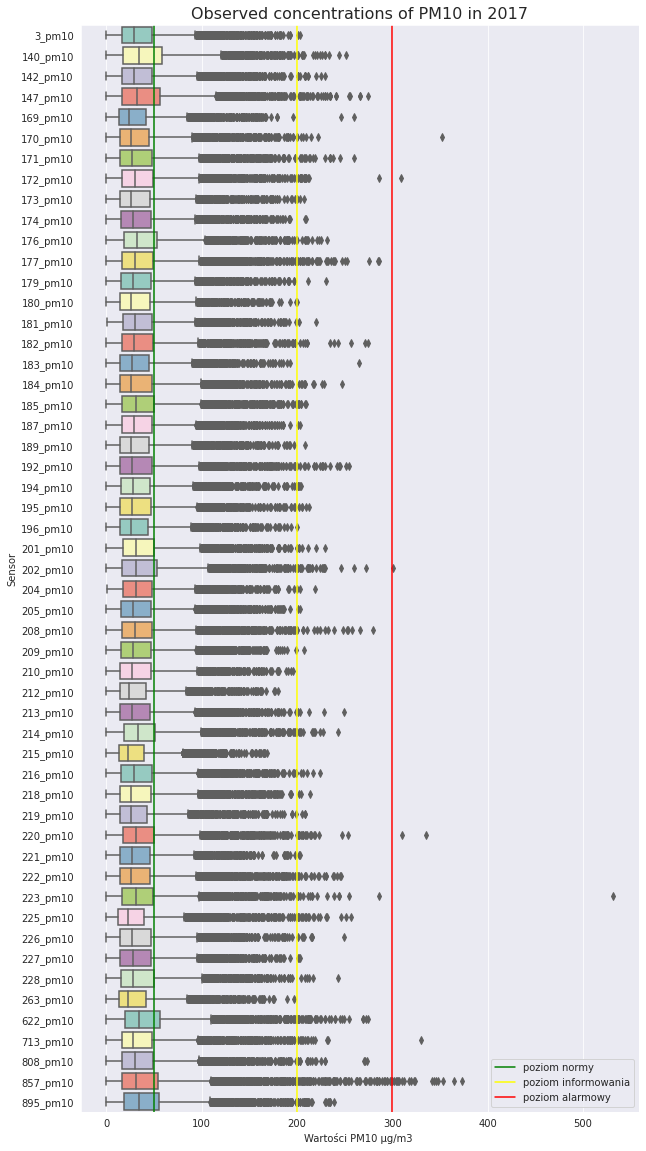

In [169]:
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.boxplot(data=pm10_col, orient="h", palette='Set3')
_ = plt.title("Observed concentrations of PM10 in 2017", fontsize=16)
_ = plt.axvline(50, color="green",label = "poziom normy")
_ = plt.axvline(200, color="yellow",label = "poziom informowania")
_ = plt.axvline(300, color="red",label = "poziom alarmowy")
_ = plt.ylabel("Sensor")
_ = plt.xlabel("Wartości PM10 µg/m3 ")
_ =plt.legend(loc="lower right")
_ = plt.show()

Wykres przedstawia rozkład wartości dla wskaźnika PM10 wraz z zaznaczoną zieloną linią normą, zaznaczoną żółtą linią po przekroczeniu której należy poinformować o wysokim wskaźniku oraz czerwoną linią, która oznaczas stan alarmowy.

In [116]:
#Połączenie nowych kolum po wyczyszczeniu danych w całość
yr_2017 = temp_col.copy()
yr_2017 = pd.concat([yr_2017,humi_col],axis=1)
yr_2017 = pd.concat([yr_2017,pres_col],axis=1)
yr_2017 = pd.concat([yr_2017,pm25_col],axis=1)
yr_2017 = pd.concat([yr_2017,pm10_col],axis=1)
yr_2017 = pd.concat([yr_2017,pm1_col],axis=1)
yr_2017['UTC time']=yr_2017.index

#Korelacje czynników

Do sprawdzenia koralacji pomiędzy cechami użyto uzupełnionych danych. 

In [117]:
#Stworzenie grup parametrów do określenia korelacji

temp_col1 = [col for col in yr_2017 if 'temperature' in col or col.startswith('UTC time')]
humi_col1 = [col for col in yr_2017 if 'humidity' in col or col.startswith('UTC time')]
pres_col1 = [col for col in yr_2017 if 'pressure' in col or col.startswith('UTC time')]
pm25_col1 = [col for col in yr_2017 if 'pm25' in col or col.startswith('UTC time')]
pm10_col1 = [col for col in yr_2017 if 'pm10' in col or col.startswith('UTC time')]
pm1_col1 = [col for col in yr_2017 if col.endswith('pm1') or col.startswith('UTC time')]

melt_temp = pd.melt(yr_2017[temp_col1], id_vars="UTC time",var_name="Temp_sensor_id", value_name='Temperature')
melt_humi = pd.melt(yr_2017[humi_col1],id_vars="UTC time", var_name="Humi_sensor_id", value_name='Humidity')
melt_pres = pd.melt(yr_2017[pres_col1], id_vars="UTC time",var_name="Pres_sensor_id", value_name='Pressure')
melt_pm25 = pd.melt(yr_2017[pm25_col1], id_vars="UTC time",var_name="pm25_sensor_id", value_name='pm25')
melt_pm10 = pd.melt(yr_2017[pm10_col1], id_vars="UTC time",var_name="pm10_sensor_id", value_name='pm10')
melt_pm1 = pd.melt(yr_2017[pm1_col1], id_vars="UTC time",var_name="pm1_sensor_id", value_name='pm1')

year_melted = pd.concat([melt_temp, melt_humi.iloc[:,1:], melt_pres.iloc[:,1:],  melt_pm25.iloc[:,1:], melt_pm10.iloc[:,1:], melt_pm1.iloc[:,1:] ], axis=1)

In [118]:
year_melted

UTC time   Temp_sensor_id  Temperature Humi_sensor_id  \
0      2017-03-01 00:00:00    3_temperature     9.617021     3_humidity   
1      2017-03-01 01:00:00    3_temperature     9.600000     3_humidity   
2      2017-03-01 02:00:00    3_temperature     7.869565     3_humidity   
3      2017-03-01 03:00:00    3_temperature     5.239130     3_humidity   
4      2017-03-01 04:00:00    3_temperature     4.733333     3_humidity   
...                    ...              ...          ...            ...   
380376 2017-12-24 20:00:00  895_temperature     5.000000   895_humidity   
380377 2017-12-24 21:00:00  895_temperature     5.000000   895_humidity   
380378 2017-12-24 22:00:00  895_temperature     5.000000   895_humidity   
380379 2017-12-24 23:00:00  895_temperature     5.000000   895_humidity   
380380 2017-12-25 00:00:00  895_temperature     5.000000   895_humidity   

         Humidity Pres_sensor_id  Pressure pm25_sensor_id  pm25  \
0       54.340426     3_pressure   99636.0         3_pm25   1.0   
1       54.622222     3_pressure   99622.0         3_pm25   0.0   
2       71.108696     3_pressure   99681.0         3_pm25   3.0   
3       87.391304     3_pressure   99825.0         3_pm25   6.0   
4       85.311111     3_pressure   99920.0         3_pm25   4.0   
...           ...            ...       ...            ...   ...   
380376  85.000000   895_pressure  101798.0       895_pm25  15.0   
380377  85.000000   895_pressure  101840.0       895_pm25  13.0   
380378  82.000000   895_pressure  101839.0       895_pm25  12.0   
380379  85.000000   895_pressure  101837.0       895_pm25  12.0   
380380  85.000000   895_pressure  101840.0       895_pm25  11.0   

       pm10_sensor_id  pm10 pm1_sensor_id   pm1  
0              3_pm10  10.0         3_pm1   8.0  
1              3_pm10   8.0         3_pm1   6.0  
2              3_pm10  12.0         3_pm1  10.0  
3              3_pm10  17.0         3_pm1  13.0  
4              3_pm10  13.0         3_pm1  10.0  
...               ...   ...           ...   ...  
380376       895_pm10  26.0       895_pm1  13.0  
380377       895_pm10  23.0       895_pm1  12.0  
380378       895_pm10  21.0       895_pm1  10.0  
380379       895_pm10  21.0       895_pm1  10.0  
380380       895_pm10  20.0       895_pm1  10.0  

[380381 rows x 13 columns]

Dodatkowo sprawdzono czy na którymś z zensorów występują szczególnie wysokie wartości Pm10 (może jest w pobliżu fabryki?) W tym celu wykorzystano posortowane po wartości PM10 dane i dla 100 największych wartości zliczono ile razy występuje poszczególny czujnik.

In [119]:
hundred_the_biggest_pm10 = year_melted.sort_values('pm10').tail(100)
hundred_the_biggest_pm10['pm10_sensor_id'].value_counts()

857_pm10    51
622_pm10     6
147_pm10     5
177_pm10     5
208_pm10     5
220_pm10     3
223_pm10     3
182_pm10     3
202_pm10     3
808_pm10     3
225_pm10     2
192_pm10     2
172_pm10     2
183_pm10     1
713_pm10     1
226_pm10     1
169_pm10     1
171_pm10     1
140_pm10     1
170_pm10     1
Name: pm10_sensor_id, dtype: int64

Jak widać powyżej w 100 najwyższych pozycjach, 50 razy występuje jeden z sensorów. Prawdopodobnie duży wpływ na jego pomiary ma lokalizacja w której się znajduje.

<Figure size 2160x2160 with 0 Axes>

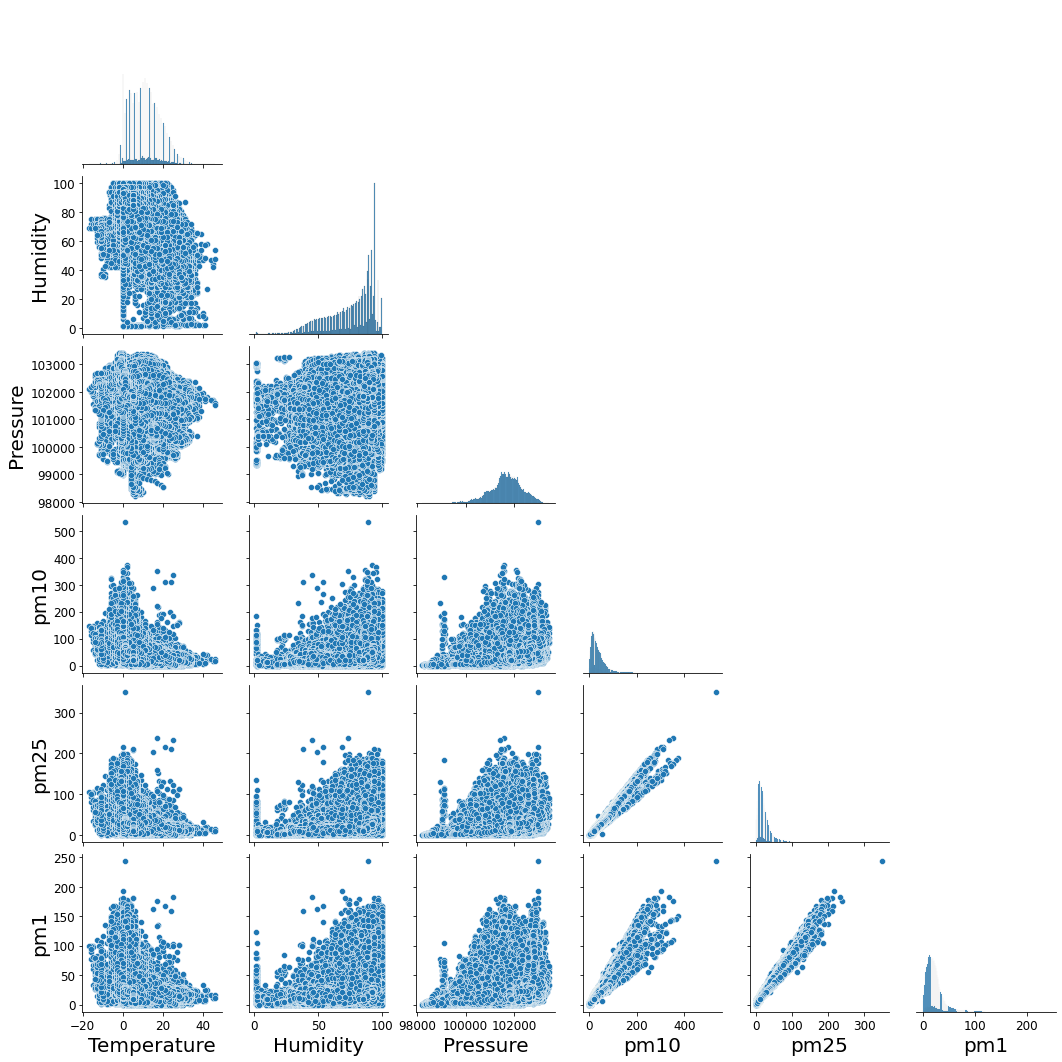

In [120]:
plt.figure(figsize=(30,30))
with sns.plotting_context(rc={"axes.labelsize":20,
                              'xtick.labelsize': 12,
                              'ytick.labelsize': 12,}):
  sns.pairplot(data=year_melted[['Temperature','Humidity','Pressure', "pm10", 'pm25', 'pm1']], corner=True, markers=["o", "s"], palette="Set1")
plt.show()

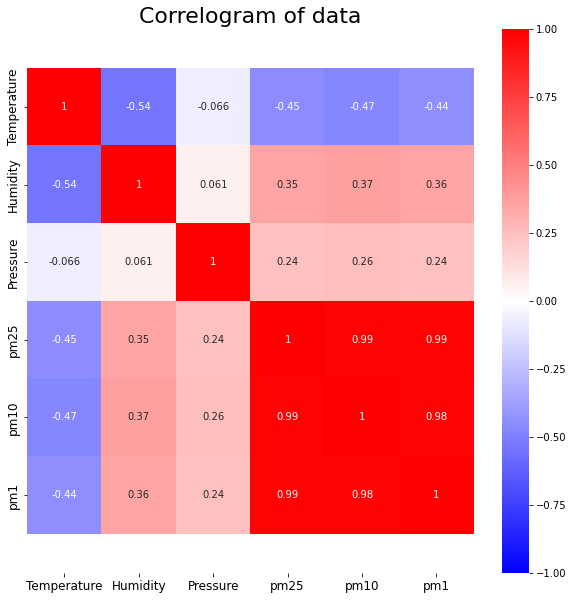

In [121]:
print_corelogram(year_melted,size=(10, 10))

Jeżeli chodzi o wskaźnik P10, który jest targetem jest on skorelowany w dużym stopniu ze wskaźnikami P25 oraz P1, dlatego, że są to wskaźniki zanieczyszczenia powietrza - więc są wzajemnie od siebie zależne. Wskaźniki P1 oraz P25 nie będą uwzględnione a modelu prognozy. Jeżeli chodzi o pozostałe cechy to największa wartość korelacji jest dla temperatury. Istotne jest to, że jeżeli wartość temperatury rośnie/spada to wartość wskaźnika P10 zachowuje się odwrotnie. Zapewnw spowodowane jest to występowaniem w Krakowie dużego Smogu w miesiącach zimowych (niskie temperatury) głównie z przyczyny ogrzewania mieszkań za pomocą pieców na paliwa stałe a także spaliny samochodowe. W letnie miesiące (temperatuta wyższa), kiedy ogrzewanie mieszkań nie jest stosowane, smog jest zdecydowanie mniejszy.

Pozostałe czynniki takie jak ciścienie i wilgotność wykazują mniejszą korelację, jednak również wpływają na współczynnik zanieczyszczenia.



#Przygotowanie wyjściowego Data Frame dla prognoz

W związku z tym, że alalizę wykonujemy prognozując zanieczyszczenie powietrza dla konkretnej dzielnicy, dane zagregowano wyciągając średnią wartość z sensorów należących do poszczególnych dzielnic

##Tablice parametrów z danymi o każdej z dzielnic

In [122]:
# tabele parametrów, w których dla parametru jest każda dzielnica
temp_col_dist = change_colfor_districts('_temperature',temp_col)
pres_col_dist = change_colfor_districts('_pressure',pres_col)
humi_col_dist = change_colfor_districts('_humidity',humi_col)
pm25_col_dist = change_colfor_districts('_pm25',pm25_col)
pm10_col_dist = change_colfor_districts('_pm10',pm10_col)
pm1_col_dist = change_colfor_districts('_pm1',pm1_col)

Warto przyjrzeć się zatem jak rozkłada się wysokość wskaźnika p10 dla poszczególnych dzelnic w ciągu roku

In [123]:
pm10_col_dist.head(3).round(2)

s_I_pm10  s_II_pm10  s_III_pm10  s_IV_pm10  s_V_pm10  \
UTC time                                                                    
2017-03-01 00:00:00       7.8       8.15        13.0       8.78       9.0   
2017-03-01 01:00:00       4.6       5.23         6.0       3.23       3.5   
2017-03-01 02:00:00       6.8       8.80         7.0       6.92       7.0   

                     s_VI_pm10  s_VII_pm10  s_VIII_pm10  s_IX_pm10  s_X_pm10  \
UTC time                                                                       
2017-03-01 00:00:00       7.15         8.0         5.92       21.0       5.5   
2017-03-01 01:00:00       2.23         2.0         3.38       11.5       4.0   
2017-03-01 02:00:00       8.05         8.2         8.84        6.5       7.5   

                     s_XI_pm10  s_XII_pm10  s_XIII_pm10  s_XIV_pm10  \
UTC time                                                              
2017-03-01 00:00:00        5.0         3.0         7.04        4.67   
2017-03-01 01:00:00        5.0         2.0         4.77        5.67   
2017-03-01 02:00:00        7.0         4.0         7.68        7.00   

                     s_XV_pm10  s_XVII_pm10  s_XVIII_pm10  
UTC time                                                   
2017-03-01 00:00:00        6.0          6.0           3.5  
2017-03-01 01:00:00        3.0          2.0           1.5  
2017-03-01 02:00:00        5.0          4.0           3.5

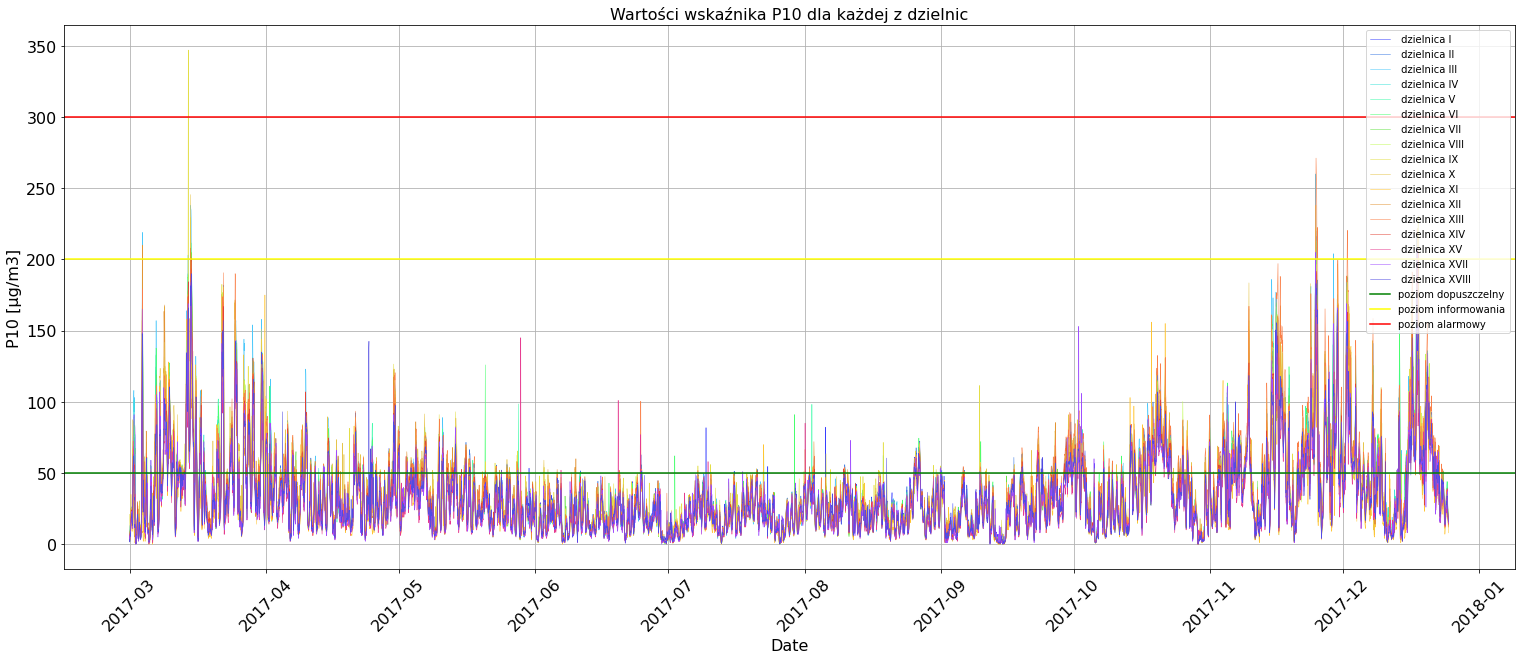

In [124]:
plt.figure(figsize=(26,10))

plt.plot(pm10_col_dist.index,pm10_col_dist['s_I_pm10'],color = '#373FFF',linewidth=0.5, label=" dzielnica I")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_II_pm10'],color = '#3979E3',linewidth=0.5, label=" dzielnica II")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_III_pm10'],color = '#4BC8FA',linewidth=0.5, label=" dzielnica III")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_IV_pm10'],color = '#39E3D8',linewidth=0.5, label=" dzielnica IV")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_V_pm10'],color = '#3FFBAA',linewidth=0.5, label=" dzielnica V")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_VI_pm10'],color = '#47FF6E',linewidth=0.5, label=" dzielnica VI")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_VII_pm10'],color = '#65E346',linewidth=0.5, label=" dzielnica VII")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_VIII_pm10'],color = '#C2FA5A',linewidth=0.5, label=" dzielnica VIII")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_IX_pm10'],color = '#E3DE46',linewidth=0.5, label=" dzielnica IX")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_X_pm10'],color = '#E6C54B',linewidth=0.5, label=" dzielnica X")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_XI_pm10'],color = '#FFC533',linewidth=0.5, label=" dzielnica XI")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_XII_pm10'],color = '#E39434',linewidth=0.5, label=" dzielnica XII")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_XIII_pm10'],color = '#FA7F47',linewidth=0.5, label=" dzielnica XIII")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_XIV_pm10'],color = '#E34334',linewidth=0.5, label=" dzielnica XIV")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_XV_pm10'],color = '#E6398E',linewidth=0.5, label=" dzielnica XV")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_XVII_pm10'],color = '#9F4DFF',linewidth=0.5, label=" dzielnica XVII")
plt.plot(pm10_col_dist.index,pm10_col_dist['s_XVIII_pm10'],color = '#504BE3',linewidth=0.5, label=" dzielnica XVIII")

plt.axhline(50, label = 'poziom dopuszczelny', color="green")
plt.axhline(200, label = 'poziom informowania', color="yellow")
plt.axhline(300, label = 'poziom alarmowy', color="red")

#title
plt.title('Wartości wskaźnika P10 dla każdej z dzielnic', fontsize=16)

#grid
plt.grid()

#labels
plt.xlabel('Date',fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('P10 [µg/m3]',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="upper right")

plt.show()

Analizując okres, który jest najbardziej istotny pod względem planowanego wydarzenia, można dostrzec, że niektóre z dzielnic mają wskaźnik P10 ponad normą. Czas na który planowane są wydarzenia plenerowe odbywanie od czerwca do września. Sprawdźmy więc jak wygląda rozłożenie wskaźnika bezpośrednio dla tego przedziału czasowego

In [125]:
#Ustawienie indexu
list(yr_2017['UTC time'])
pm10_col_dist['Date']=list(yr_2017['UTC time'])
temp_col_dist['Date']=list(yr_2017['UTC time'])
humi_col_dist['Date']=list(yr_2017['UTC time'])
pres_col_dist['Date']=list(yr_2017['UTC time'])

#Ustawienie okna czasowego

date_mask2 = (pm10_col_dist['Date'] > '2017-05-31 23:00:00')&(pm10_col_dist['Date'] < '2017-09-01 00:00:00')
pm10_col_dist_perioid = pm10_col_dist.loc[date_mask2]


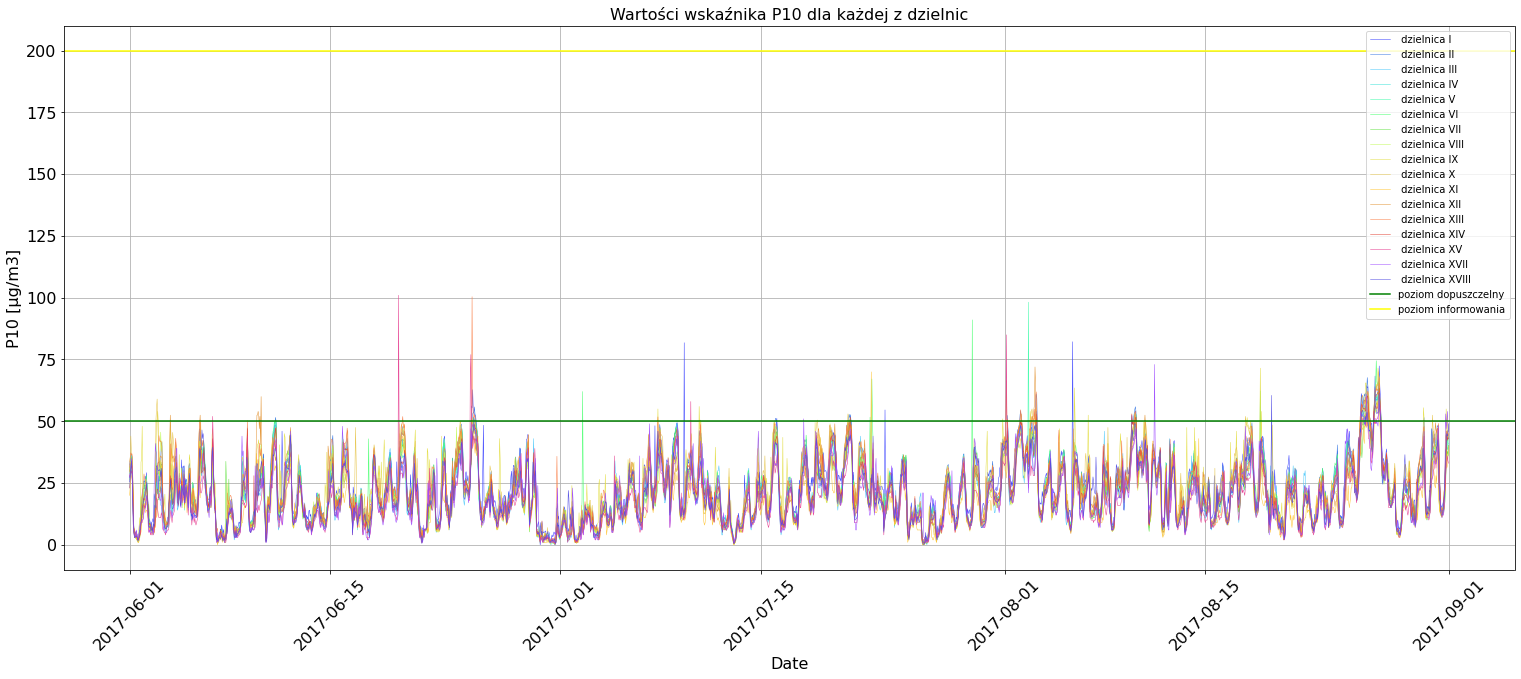

In [126]:
plt.figure(figsize=(26,10))

plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_I_pm10'],color = '#373FFF',linewidth=0.5, label=" dzielnica I")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_II_pm10'],color = '#3979E3',linewidth=0.5, label=" dzielnica II")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_III_pm10'],color = '#4BC8FA',linewidth=0.5, label=" dzielnica III")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_IV_pm10'],color = '#39E3D8',linewidth=0.5, label=" dzielnica IV")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_V_pm10'],color = '#3FFBAA',linewidth=0.5, label=" dzielnica V")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_VI_pm10'],color = '#47FF6E',linewidth=0.5, label=" dzielnica VI")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_VII_pm10'],color = '#65E346',linewidth=0.5, label=" dzielnica VII")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_VIII_pm10'],color = '#C2FA5A',linewidth=0.5, label=" dzielnica VIII")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_IX_pm10'],color = '#E3DE46',linewidth=0.5, label=" dzielnica IX")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_X_pm10'],color = '#E6C54B',linewidth=0.5, label=" dzielnica X")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_XI_pm10'],color = '#FFC533',linewidth=0.5, label=" dzielnica XI")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_XII_pm10'],color = '#E39434',linewidth=0.5, label=" dzielnica XII")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_XIII_pm10'],color = '#FA7F47',linewidth=0.5, label=" dzielnica XIII")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_XIV_pm10'],color = '#E34334',linewidth=0.5, label=" dzielnica XIV")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_XV_pm10'],color = '#E6398E',linewidth=0.5, label=" dzielnica XV")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_XVII_pm10'],color = '#9F4DFF',linewidth=0.5, label=" dzielnica XVII")
plt.plot(pm10_col_dist_perioid.index,pm10_col_dist_perioid['s_XVIII_pm10'],color = '#504BE3',linewidth=0.5, label=" dzielnica XVIII")

plt.axhline(50, label = 'poziom dopuszczelny', color="green")
plt.axhline(200, label = 'poziom informowania', color="yellow")

#title
plt.title('Wartości wskaźnika P10 dla każdej z dzielnic',fontsize=16)

#grid
plt.grid()

#labels
plt.xlabel('Date',fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('P10 [µg/m3]',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc="upper right")

plt.show()

Na wykresie można zauważyć, że w niektórych dzielnicach wastość P10 jest znacznie powyżej normy (np. dla dzielnicy IV, V i XV, natomiast niektóra utrzynują stan poniżej normy, bądź ich przekroczenia są mniejsze (np. dzielnice XII i XVII). W miesiącach letnich wartość wskaźnika nigdy nie przekroczyła poziomu alarmowego oraz informowania, co oznacza, że miesiące te są najkorzystniejszym wyborem do zaplanowania wydarzeń na powierzu, ponieważ szansa na wskaźnik przekraczający poziom informowania jest niewielki.

##Zaagregowanie danych godzinowych do dni 

Z uwagi na to, że do tej pory cały czas rozpatrywano dane godzinowe, które są bardzo szczegółowe, postanowiono je uprościć do danych dla danego dnia. Wtym celu wykorzystano medianę z wartości wskaźników dla danego dnia.

In [127]:
#Stworzenie dataframe dla każdego parametru ['Temperature', 'Pressure', 'Humidity', 'PM10'], gdzie wyciągnięto medianę z dnia
pm10 = pm10_col_dist.copy()
pm10.index = pm10["Date"].dt.to_period('d')
pm10.drop(columns=['Date'], inplace=True)
pm10 = pm10.groupby(["Date"]).median()

temp = temp_col_dist.copy()
temp.index = temp["Date"].dt.to_period('d')
temp.drop(columns=['Date'], inplace=True)
temp = temp.groupby(["Date"]).median()

pres = pres_col_dist.copy()
pres.index = pres["Date"].dt.to_period('d')
pres.drop(columns=['Date'], inplace=True)
pres = pres.groupby(["Date"]).median()

humi = humi_col_dist.copy()
humi.index = humi["Date"].dt.to_period('d')
humi.drop(columns=['Date'], inplace=True)
humi = humi.groupby(["Date"]).median()

In [128]:
#Stworzenie nowej tabeli z danymi usupełnionymi dla dzielnic
year_2017_districts = temp.copy()
year_2017_districts = pd.concat((year_2017_districts,humi),axis=1)
year_2017_districts = pd.concat((year_2017_districts,pres),axis=1)
year_2017_districts = pd.concat((year_2017_districts,pm10),axis=1)

##Stworzenie jednego finalnego Data Framu z datą, dzielicą i parametrami

In [129]:
#Tabele z dzielnicami, w których dla każdej dzielnicy są jej parametry

#DZIELNICA I
dzielnica_I = [col for col in year_2017_districts if 's_I_' in col or col.startswith('UTC time')]
dzielnica_I=year_2017_districts.filter(items=dzielnica_I)
dzielnica_I['dzielnica']='I'
dzielnica_I=dzielnica_I.rename(columns={'s_I_temperature': "temperature", 
                                              's_I_humidity': "humidity",
                                              's_I_pressure':"pressure", 
                                              's_I_pm10':"pm10"})
dzielnica_I=dzielnica_I.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA II
dzielnica_II = [col for col in year_2017_districts if 's_II_' in col or col.startswith('UTC time')]
dzielnica_II=year_2017_districts.filter(items=dzielnica_II)
dzielnica_II['dzielnica']='II'
dzielnica_II=dzielnica_II.rename(columns={'s_II_temperature': "temperature", 
                                              's_II_humidity': "humidity",
                                              's_II_pressure':"pressure", 
                                              's_II_pm10':"pm10"})
dzielnica_II=dzielnica_II.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA III
dzielnica_III = [col for col in year_2017_districts if 's_III_' in col or col.startswith('UTC time')]
dzielnica_III=year_2017_districts.filter(items=dzielnica_III)
dzielnica_III['dzielnica']='III'
dzielnica_III=dzielnica_III.rename(columns={'s_III_temperature': "temperature", 
                                              's_III_humidity': "humidity",
                                              's_III_pressure':"pressure", 
                                              's_III_pm10':"pm10"})
dzielnica_III=dzielnica_III.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA IV
dzielnica_IV = [col for col in year_2017_districts if 's_IV_' in col or col.startswith('UTC time')]
dzielnica_IV=year_2017_districts.filter(items=dzielnica_IV)
dzielnica_IV['dzielnica']='IV'
dzielnica_IV=dzielnica_IV.rename(columns={'s_IV_temperature': "temperature", 
                                              's_IV_humidity': "humidity",
                                              's_IV_pressure':"pressure", 
                                              's_IV_pm10':"pm10"})
dzielnica_IV=dzielnica_IV.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA V
dzielnica_V = [col for col in year_2017_districts if 's_V_' in col or col.startswith('UTC time')]
dzielnica_V=year_2017_districts.filter(items=dzielnica_V)
dzielnica_V['dzielnica']='V'
dzielnica_V=dzielnica_V.rename(columns={'s_V_temperature': "temperature", 
                                              's_V_humidity': "humidity",
                                              's_V_pressure':"pressure", 
                                              's_V_pm10':"pm10"})
dzielnica_V=dzielnica_V.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA VI
dzielnica_VI = [col for col in year_2017_districts if 's_VI_' in col or col.startswith('UTC time')]
dzielnica_VI=year_2017_districts.filter(items=dzielnica_VI)
dzielnica_VI['dzielnica']='VI'
dzielnica_VI=dzielnica_VI.rename(columns={'s_VI_temperature': "temperature", 
                                              's_VI_humidity': "humidity",
                                              's_VI_pressure':"pressure", 
                                              's_VI_pm10':"pm10"})
dzielnica_VI=dzielnica_VI.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA VII
dzielnica_VII = [col for col in year_2017_districts if 's_VII_' in col or col.startswith('UTC time')]
dzielnica_VII=year_2017_districts.filter(items=dzielnica_VII)
dzielnica_VII['dzielnica']='VII'
dzielnica_VII=dzielnica_VII.rename(columns={'s_VII_temperature': "temperature", 
                                              's_VII_humidity': "humidity",
                                              's_VII_pressure':"pressure", 
                                              's_VII_pm10':"pm10"})
dzielnica_VII=dzielnica_VII.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA VIII
dzielnica_VIII = [col for col in year_2017_districts if 's_VIII_' in col or col.startswith('UTC time')]
dzielnica_VIII=year_2017_districts.filter(items=dzielnica_VIII)
dzielnica_VIII['dzielnica']='VIII'
dzielnica_VIII=dzielnica_VIII.rename(columns={'s_VIII_temperature': "temperature", 
                                              's_VIII_humidity': "humidity",
                                              's_VIII_pressure':"pressure", 
                                              's_VIII_pm10':"pm10"})
dzielnica_VIII=dzielnica_VIII.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA IX
dzielnica_IX = [col for col in year_2017_districts if 's_IX_' in col or col.startswith('UTC time')]
dzielnica_IX=year_2017_districts.filter(items=dzielnica_IX)
dzielnica_IX['dzielnica']='IX'
dzielnica_IX=dzielnica_IX.rename(columns={'s_IX_temperature': "temperature", 
                                              's_IX_humidity': "humidity",
                                              's_IX_pressure':"pressure", 
                                              's_IX_pm10':"pm10"})
dzielnica_IX=dzielnica_IX.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA X
dzielnica_X = [col for col in year_2017_districts if 's_X_' in col or col.startswith('UTC time')]
dzielnica_X=year_2017_districts.filter(items=dzielnica_X)
dzielnica_X['dzielnica']='X'
dzielnica_X=dzielnica_X.rename(columns={'s_X_temperature': "temperature", 
                                              's_X_humidity': "humidity",
                                              's_X_pressure':"pressure", 
                                              's_X_pm10':"pm10"})
dzielnica_X=dzielnica_X.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA XI
dzielnica_XI = [col for col in year_2017_districts if 's_XI_' in col or col.startswith('UTC time')]
dzielnica_XI=year_2017_districts.filter(items=dzielnica_XI)
dzielnica_XI['dzielnica']='XI'
dzielnica_XI=dzielnica_XI.rename(columns={'s_XI_temperature': "temperature", 
                                              's_XI_humidity': "humidity",
                                              's_XI_pressure':"pressure", 
                                              's_XI_pm10':"pm10"})
dzielnica_XI=dzielnica_XI.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA XII
dzielnica_XII = [col for col in year_2017_districts if 's_XII_' in col or col.startswith('UTC time')]
dzielnica_XII=year_2017_districts.filter(items=dzielnica_XII)
dzielnica_XII['dzielnica']='XII'
dzielnica_XII=dzielnica_XII.rename(columns={'s_XII_temperature': "temperature", 
                                              's_XII_humidity': "humidity",
                                              's_XII_pressure':"pressure", 
                                              's_XII_pm10':"pm10"})
dzielnica_XII=dzielnica_XII.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA XIII
dzielnica_XIII = [col for col in year_2017_districts if 's_XIII_' in col or col.startswith('UTC time')]
dzielnica_XIII=year_2017_districts.filter(items=dzielnica_XIII)
dzielnica_XIII['dzielnica']='XIII'
dzielnica_XIII=dzielnica_XIII.rename(columns={'s_XIII_temperature': "temperature", 
                                              's_XIII_humidity': "humidity",
                                              's_XIII_pressure':"pressure", 
                                              's_XIII_pm10':"pm10"})
dzielnica_XIII=dzielnica_XIII.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA XVI
dzielnica_XIV = [col for col in year_2017_districts if 's_XIV_' in col or col.startswith('UTC time')]
dzielnica_XIV=year_2017_districts.filter(items=dzielnica_XIV)
dzielnica_XIV['dzielnica']='XIV'
dzielnica_XIV=dzielnica_XIV.rename(columns={'s_XIV_temperature': "temperature", 
                                              's_XIV_humidity': "humidity",
                                              's_XIV_pressure':"pressure", 
                                              's_XIV_pm10':"pm10"})
dzielnica_XIV=dzielnica_XIV.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA XV
dzielnica_XV = [col for col in year_2017_districts if 's_XV_' in col or col.startswith('UTC time')]
dzielnica_XV=year_2017_districts.filter(items=dzielnica_XV)
dzielnica_XV['dzielnica']='XV'
dzielnica_XV=dzielnica_XV.rename(columns={'s_XV_temperature': "temperature", 
                                              's_XV_humidity': "humidity",
                                              's_XV_pressure':"pressure", 
                                              's_XV_pm10':"pm10"})
dzielnica_XV=dzielnica_XV.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA XVII
dzielnica_XVII = [col for col in year_2017_districts if 's_XVII_' in col or col.startswith('UTC time')]
dzielnica_XVII=year_2017_districts.filter(items=dzielnica_XVII)
dzielnica_XVII['dzielnica']='XVII'
dzielnica_XVII=dzielnica_XVII.rename(columns={'s_XVII_temperature': "temperature", 
                                              's_XVII_humidity': "humidity",
                                              's_XVII_pressure':"pressure", 
                                              's_XVII_pm10':"pm10"})
dzielnica_XVII=dzielnica_XVII.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

#DZIELNICA XVIII
dzielnica_XVIII = [col for col in year_2017_districts if 's_XVIII_' in col or col.startswith('UTC time')]
dzielnica_XVIII=year_2017_districts.filter(items=dzielnica_XVIII)
dzielnica_XVIII['dzielnica']='XVIII'
dzielnica_XVIII=dzielnica_XVIII.rename(columns={'s_XVIII_temperature': "temperature", 
                                              's_XVIII_humidity': "humidity",
                                              's_XVIII_pressure':"pressure", 
                                              's_XVIII_pm10':"pm10"})
dzielnica_XVIII=dzielnica_XVIII.loc[:,['dzielnica', 'temperature', 'humidity', 'pressure', 'pm10'  ]]

In [130]:
all_data = dzielnica_I.copy()
all_data = all_data.append(dzielnica_II)
all_data = all_data.append(dzielnica_III)
all_data = all_data.append(dzielnica_IV)
all_data = all_data.append(dzielnica_V)
all_data = all_data.append(dzielnica_VI)
all_data = all_data.append(dzielnica_VII)
all_data = all_data.append(dzielnica_VIII)
all_data = all_data.append(dzielnica_IX)
all_data = all_data.append(dzielnica_X)
all_data = all_data.append(dzielnica_XI)
all_data = all_data.append(dzielnica_XII)
all_data = all_data.append(dzielnica_XIII)
all_data = all_data.append(dzielnica_XIV)
all_data = all_data.append(dzielnica_XV)
all_data = all_data.append(dzielnica_XVII)
all_data = all_data.append(dzielnica_XVIII)
all_data = all_data.sort_index()

In [131]:
dzielnica_I

dzielnica  temperature   humidity       pressure       pm10
Date                                                                  
2017-03-01         I     5.200000  69.000000  100442.723810  20.600000
2017-03-02         I     5.400000  55.700000  100827.908571  16.500000
2017-03-03         I     3.300000  67.600000  101613.399076  12.526087
2017-03-04         I    10.800000  46.900000  100545.117143  36.900000
2017-03-05         I    12.200000  47.000000  100544.071429  10.700000
...              ...          ...        ...            ...        ...
2017-12-21         I     0.100000  87.100000  102667.100000  65.400000
2017-12-22         I     2.400000  92.700000  102623.700000  48.500000
2017-12-23         I     2.400000  88.700000  102127.900000  35.900000
2017-12-24         I     5.990244  88.301987  101745.843902  22.790000
2017-12-25         I     5.419048  84.995122  101791.273171  13.429268

[300 rows x 5 columns]

##Widok finalnej tabeli do prognoz

In [132]:
all_data

dzielnica  temperature   humidity       pressure       pm10
Date                                                                  
2017-03-01         I     5.200000  69.000000  100442.723810  20.600000
2017-03-01       XIV     5.000000  68.666667  100431.666667  19.833333
2017-03-01      XIII     5.091739  69.000000  100438.416667  21.771184
2017-03-01        VI     5.118116  70.625000  100403.029762  20.646739
2017-03-01        IV     4.919519  69.687500  100393.886905  22.165761
...              ...          ...        ...            ...        ...
2017-12-25        II     5.523810  86.243902  101832.591463  15.036585
2017-12-25        XV     5.000000  88.000000  101826.000000  14.000000
2017-12-25         I     5.419048  84.995122  101791.273171  13.429268
2017-12-25        XI     5.000000  85.000000  101807.000000   8.000000
2017-12-25     XVIII     5.047619  83.975610  101706.682927  15.573171

[5100 rows x 5 columns]

Finalna tabela na której można pracować z modelami zawiera index w postaci daty, dzielnicę, numer dzielnicy, który jest daną kategoryczną, parametry temperatury, wilgotności oraz ciśnienia, a takżę kolumnę z targetem - PM10.

#Przygotowanie danych do modelu

##Zamiana kolumny dzielnica na One Hot Encoder

W tabeli występują dane kategoryczne, które zależy zamienić na 0, 1 np. przy zastosowaniu funkcji OneHotEncoder()

In [133]:
all_data_numeric = all_data.drop(columns={'dzielnica','pm10'})
dzielnica_ohe = pd.get_dummies(all_data['dzielnica'], drop_first=True) #zamiana kategorii na 0/1
all_data_ohe = pd.concat([all_data_numeric,dzielnica_ohe],axis=1)
all_data_ohe

temperature   humidity       pressure  II  III  IV  IX  V  VI  \
Date                                                                        
2017-03-01     5.200000  69.000000  100442.723810   0    0   0   0  0   0   
2017-03-01     5.000000  68.666667  100431.666667   0    0   0   0  0   0   
2017-03-01     5.091739  69.000000  100438.416667   0    0   0   0  0   0   
2017-03-01     5.118116  70.625000  100403.029762   0    0   0   0  0   1   
2017-03-01     4.919519  69.687500  100393.886905   0    0   1   0  0   0   
...                 ...        ...            ...  ..  ...  ..  .. ..  ..   
2017-12-25     5.523810  86.243902  101832.591463   1    0   0   0  0   0   
2017-12-25     5.000000  88.000000  101826.000000   0    0   0   0  0   0   
2017-12-25     5.419048  84.995122  101791.273171   0    0   0   0  0   0   
2017-12-25     5.000000  85.000000  101807.000000   0    0   0   0  0   0   
2017-12-25     5.047619  83.975610  101706.682927   0    0   0   0  0   0   

            VII  VIII  X  XI  XII  XIII  XIV  XV  XVII  XVIII  
Date                                                           
2017-03-01    0     0  0   0    0     0    0   0     0      0  
2017-03-01    0     0  0   0    0     0    1   0     0      0  
2017-03-01    0     0  0   0    0     1    0   0     0      0  
2017-03-01    0     0  0   0    0     0    0   0     0      0  
2017-03-01    0     0  0   0    0     0    0   0     0      0  
...         ...   ... ..  ..  ...   ...  ...  ..   ...    ...  
2017-12-25    0     0  0   0    0     0    0   0     0      0  
2017-12-25    0     0  0   0    0     0    0   1     0      0  
2017-12-25    0     0  0   0    0     0    0   0     0      0  
2017-12-25    0     0  0   1    0     0    0   0     0      0  
2017-12-25    0     0  0   0    0     0    0   0     0      1  

[5100 rows x 19 columns]

##Podział zbioru na treningowy i testowy

Ponieważ rozwiązywany problem należy do problemu szeregów czasowych, dane na zbiór testowy i treningowy podzielono zgodnie z kolejnością ich występowania czyli dla zbioru treningowego przypisano obserwacje od marca do października, a dla zbioru testowego pozostałe - od listopada do grudnia

In [134]:
#Podział zbioru na treningowy i testowy
y = all_data['pm10'].copy()
X1= all_data_ohe

y_train = y.head(4165)
y_test = y.tail(935)

X1_train = X1.head(4165)
X1_test = X1.tail(935)


#Dummy model

Dummy model - jest modelem do którego porównane zostane będą utworzone modele. Wszystkie modele powinny mieć lepsze parametry niż ten model.

In [135]:
# Stworzenie modelu, do którego możena porównać nowo stworzone modele
dummy_model = DummyRegressor(strategy='mean') # użycie dummymodel jako model porównawczy
dummy_model.fit(X1_train, y_train) #trenowanie
y_train_dummy = dummy_model.predict(X1_train) #przewidywany y_dummy na zbiorze treningowym
y_test_dummy  = dummy_model.predict(X1_test) #przewidywany y_dummy na zbiorze testowym

In [136]:
calculate_metrics("Dummy Model",y_train,y_test,y_train_dummy, y_test_dummy)

Model   R2  MAE_train   MAE_test  MAPE_train [%]  MAPE_test [%]  \
0  Dummy Model  0.0  13.247796  27.706997       89.082009       55.91438   

   RMSE_train  RMSE_test  
0   17.707826  35.447713

#Drzewo decyzyjne 1

Pierwszym modelem jest drzewo decyzyjne. Jest to model nieparametryczny, więc nie wymaga standaryzacji danych. Do dobrania dla niego najlepszych parametrów posłużono się GridSearchem, które sprawdza najlepsze kombinacje zaproponowanych parametrów. W cross walidacji w tym jak i kolejnych modelach wykorzystano TimeSeriesSplit, który nie rozdziela zbiorów walidacyjnych wybierając przypadkowy zbiór, tylko dzieli je na zbiory uwzględniając ich kolejność występowania w czasie

In [137]:
tscv = TimeSeriesSplit(n_splits=5).split(X1_train)

tree_model_1 = DecisionTreeRegressor()
# Nasz model sprawdzi poniższe hiperparametry
params = {'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13], 
          'min_samples_leaf':[3,5,7,9,11,13,15,17,19,23,25,27]}

tree_gridsearch1 = GridSearchCV(tree_model_1, 
                                                params,
                                                scoring='neg_mean_squared_error', #dla problemów regresji 
                                                cv=tscv,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
tree_gridsearch1.fit(X1_train, y_train)
print('\nBest hyperparameter:', tree_gridsearch1.best_params_)

tree_model_1 = tree_gridsearch1.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5; 1/144] START max_depth=2, min_samples_leaf=3...........................
[CV 1/5; 1/144] END max_depth=2, min_samples_leaf=3;, score=-595.855 total time=   0.0s
[CV 2/5; 1/144] START max_depth=2, min_samples_leaf=3...........................
[CV 2/5; 1/144] END max_depth=2, min_samples_leaf=3;, score=-404.100 total time=   0.0s
[CV 3/5; 1/144] START max_depth=2, min_samples_leaf=3...........................
[CV 3/5; 1/144] END max_depth=2, min_samples_leaf=3;, score=-124.925 total time=   0.0s
[CV 4/5; 1/144] START max_depth=2, min_samples_leaf=3...........................
[CV 4/5; 1/144] END max_depth=2, min_samples_leaf=3;, score=-245.097 total time=   0.0s
[CV 5/5; 1/144] START max_depth=2, min_samples_leaf=3...........................
[CV 5/5; 1/144] END max_depth=2, min_samples_leaf=3;, score=-469.829 total time=   0.0s
[CV 1/5; 2/144] START max_depth=2, min_samples_leaf=5...........................
[CV 1/5; 2/

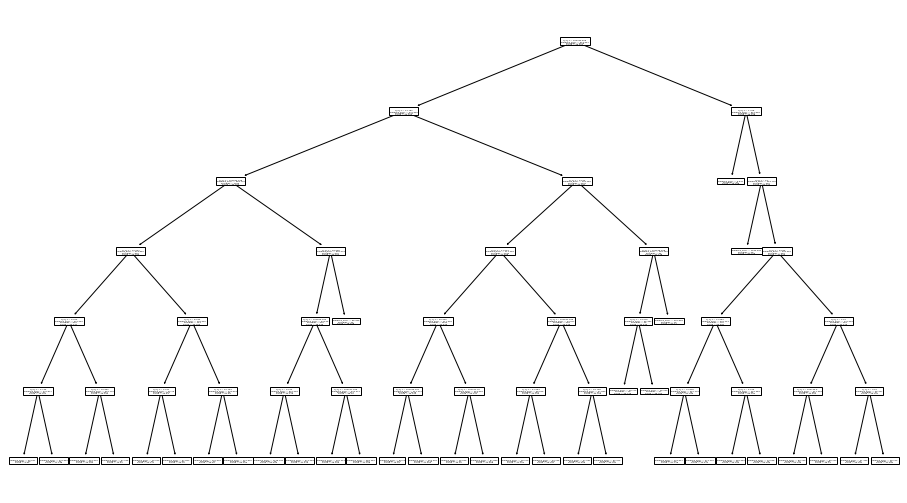

In [138]:
# wykres przedstawiający kolejne kroki drzewa decyzyjnego    
plt.figure(figsize=(16,9))
tree.plot_tree(tree_model_1)
plt.show()

In [139]:
# Przewidywany y na zbiorze treningowym i testowym
y_predict_train_model_tree1 = tree_model_1.predict(X1_train)
y_predict_test_model_tree1 = tree_model_1.predict(X1_test)

In [140]:
calculate_metrics("Drzewo decyzyjne 1",y_train,y_test,y_predict_train_model_tree1, y_predict_test_model_tree1)

Model       R2  MAE_train   MAE_test  MAPE_train [%]  \
0         Dummy Model  0.00000  13.247796  27.706997       89.082009   
1  Drzewo decyzyjne 1  0.52886   8.959954  29.514629       56.425110   

   MAPE_test [%]  RMSE_train  RMSE_test  
0      55.914380   17.707826  35.447713  
1      59.303356   12.154589  38.130495

Dummy model


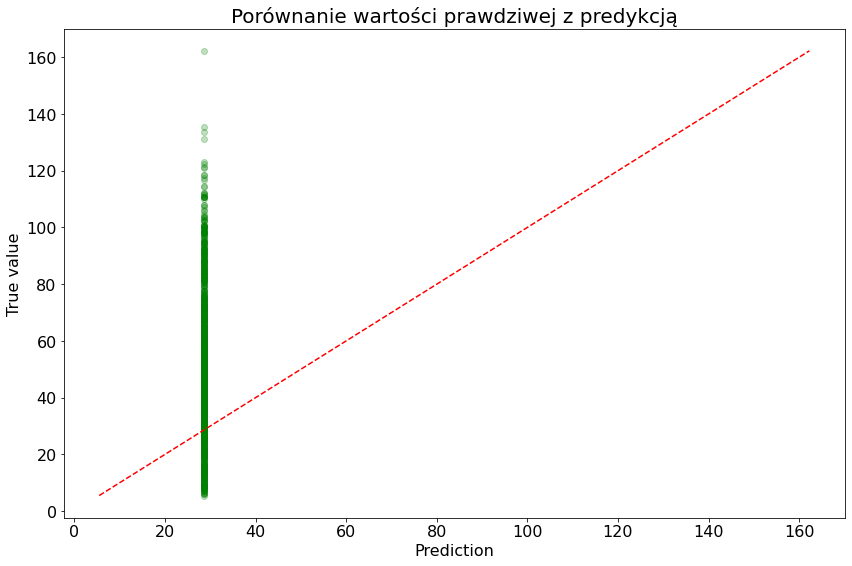

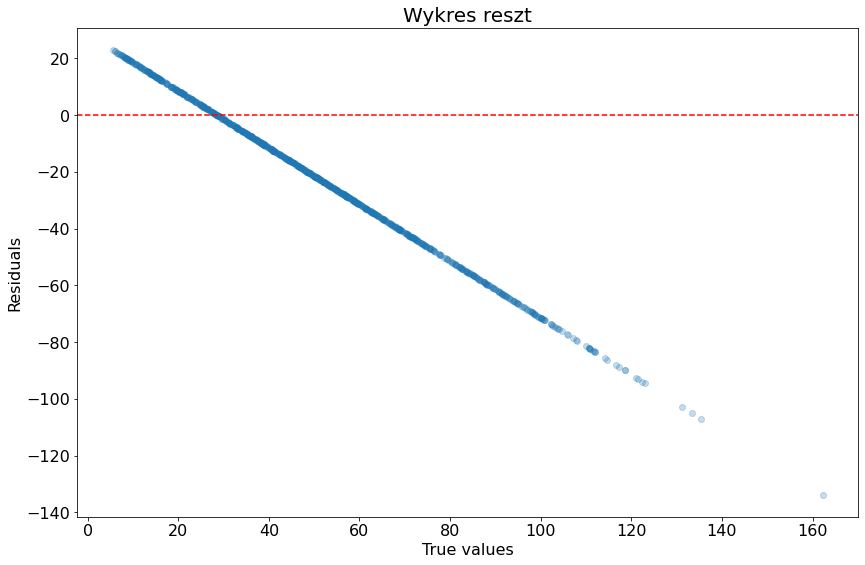

Średni błąd: -23.041677533530482


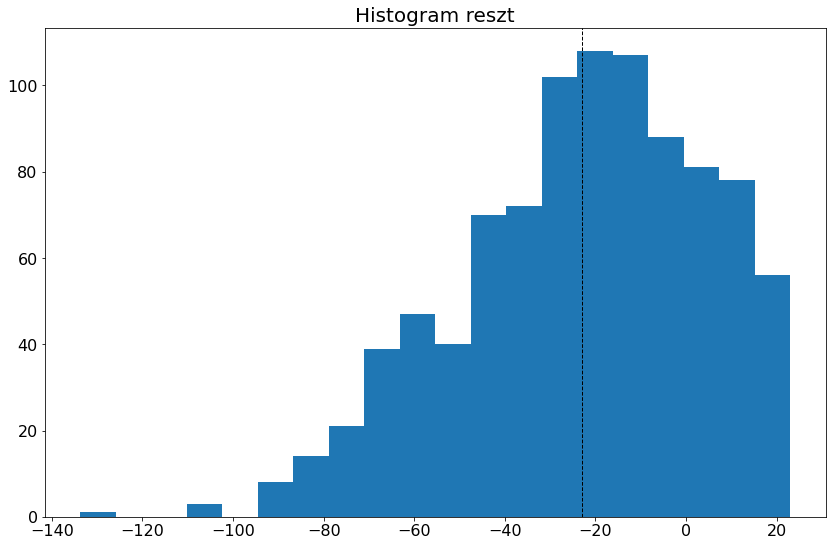

In [141]:
print('Dummy model')
plot_evaluation(y_test_dummy,y_test)

Drzewo decyzyjne 1


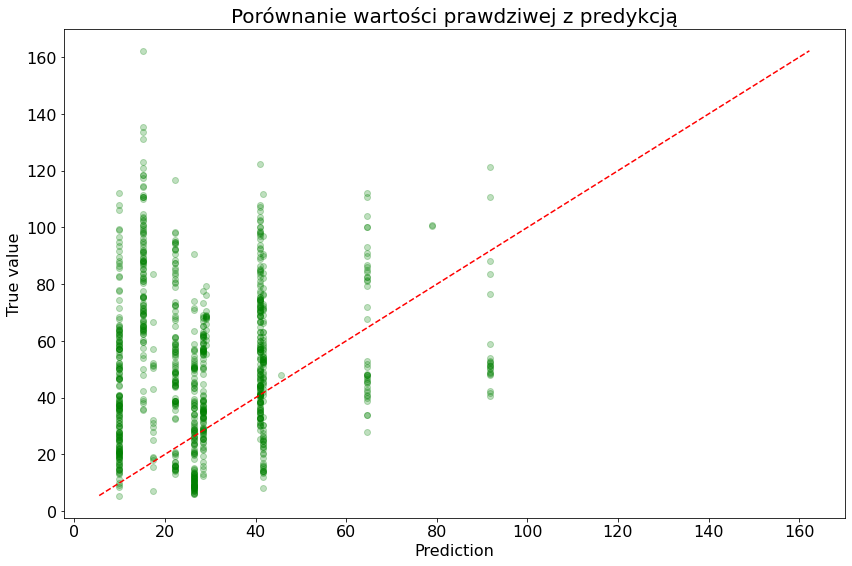

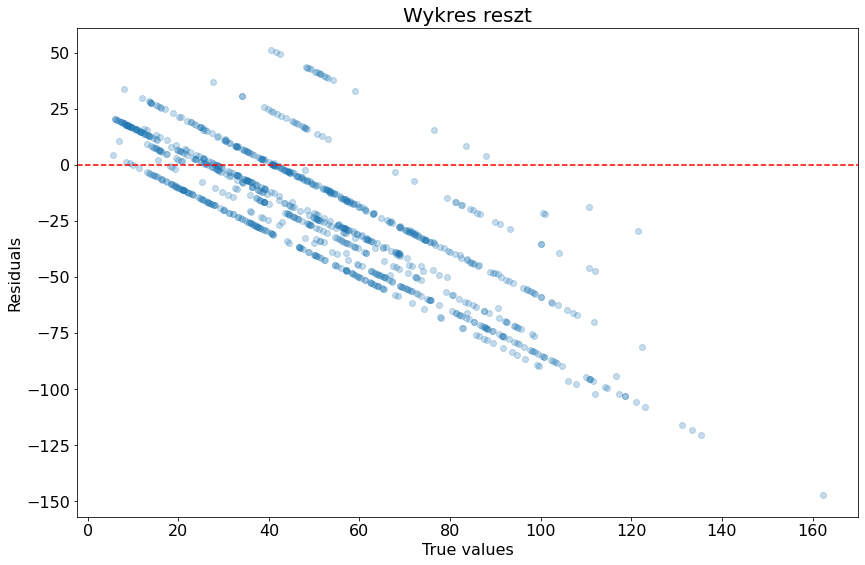

Średni błąd: -22.727978897078682


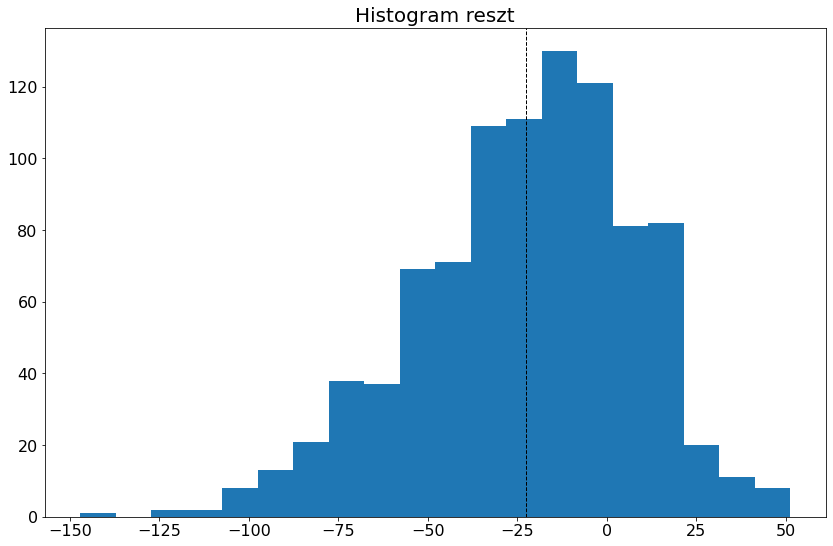

In [142]:
print('Drzewo decyzyjne 1')
plot_evaluation(y_predict_test_model_tree1,y_test)

Na podstawie metryk oraz wykresów ewaluacyjnych można dostrzec, że model nie daje dobrych wyników. Na wykresie reszt widać zależność, która nie powinna występować. Wartość przewidywane nie zmierzają do wartości przewidywanych. Prawdopodobnie istnieje czynnik, którego nie uwzględnono w modelu.

#Ponowne przygotowanie danych

Ponieważ pierwszy model nie działa zbyt dobrze, zastosowano próbę dodanie nowych cech takich jak:
 - dzień tygodnia

In [143]:
#Przypidanie do każdej daty dnia tygodnia
all_data2 = all_data.copy()
all_data2['Date']=all_data2.index
all_data2['day']=all_data2['Date'].apply(lambda x: x.strftime("%A"))
all_data2=all_data2.drop(columns=['Date'])

#Złączenie wszystkich danych i zamiana ich wartości na OHE
all_data_numeric = all_data.drop(columns={'dzielnica','pm10'})
dzielnica_ohe = pd.get_dummies(all_data['dzielnica'], drop_first=True) #zamiana kategorii na 0/1
day_ohe = pd.get_dummies(all_data2['day'], drop_first=True) #zamiana kategorii na 0/1
all_data2_ohe = pd.concat([all_data_numeric,dzielnica_ohe],axis=1)
all_data2_ohe = pd.concat([all_data2_ohe,day_ohe],axis=1)


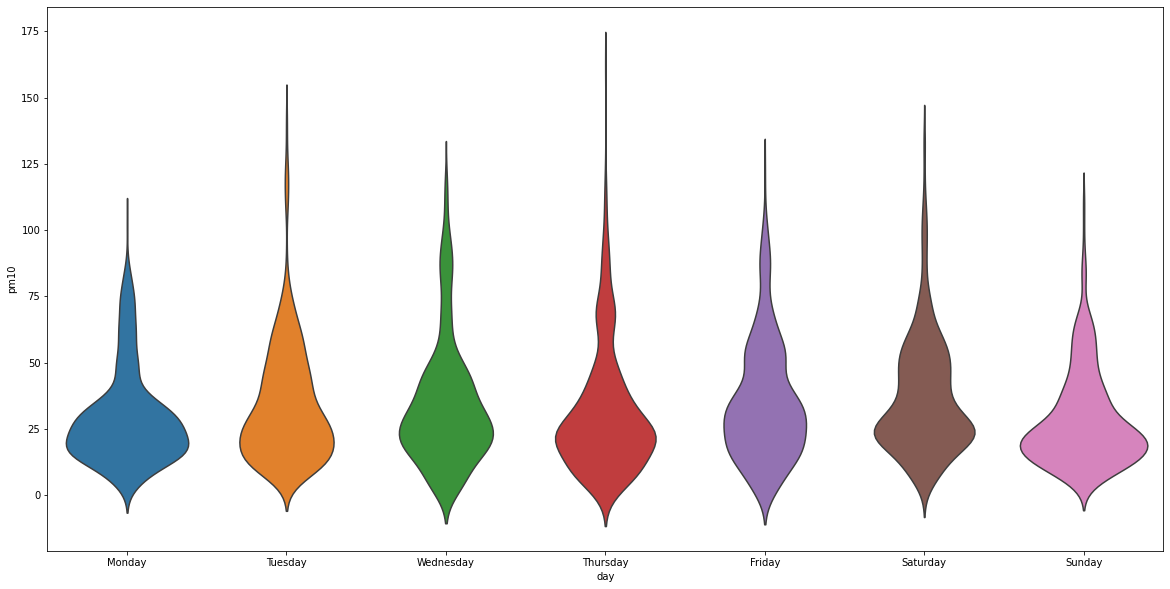

In [144]:
#Wykres przedstawiający wskaźnik PM10 wg dni tygodnia
fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style('darkgrid')
sns.violinplot(data=all_data2, x='day', y='pm10',order=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"],inner = None)

Pomimo, że spodziewano się znacznych różnic dla wykresów reprezentujących wartości zanieczyszczenia w sobotę i niedzielę, nie zaobserwowano widocznych zależności wartości PM10 od dnia tygodnia. Jednak podjęto próbę uwzględnienia tej cechy w kolejnych modelach.

In [145]:
all_data2_ohe

temperature   humidity       pressure  II  III  IV  IX  V  VI  \
Date                                                                        
2017-03-01     5.200000  69.000000  100442.723810   0    0   0   0  0   0   
2017-03-01     5.000000  68.666667  100431.666667   0    0   0   0  0   0   
2017-03-01     5.091739  69.000000  100438.416667   0    0   0   0  0   0   
2017-03-01     5.118116  70.625000  100403.029762   0    0   0   0  0   1   
2017-03-01     4.919519  69.687500  100393.886905   0    0   1   0  0   0   
...                 ...        ...            ...  ..  ...  ..  .. ..  ..   
2017-12-25     5.523810  86.243902  101832.591463   1    0   0   0  0   0   
2017-12-25     5.000000  88.000000  101826.000000   0    0   0   0  0   0   
2017-12-25     5.419048  84.995122  101791.273171   0    0   0   0  0   0   
2017-12-25     5.000000  85.000000  101807.000000   0    0   0   0  0   0   
2017-12-25     5.047619  83.975610  101706.682927   0    0   0   0  0   0   

            VII  ...  XIV  XV  XVII  XVIII  Monday  Saturday  Sunday  \
Date             ...                                                   
2017-03-01    0  ...    0   0     0      0       0         0       0   
2017-03-01    0  ...    1   0     0      0       0         0       0   
2017-03-01    0  ...    0   0     0      0       0         0       0   
2017-03-01    0  ...    0   0     0      0       0         0       0   
2017-03-01    0  ...    0   0     0      0       0         0       0   
...         ...  ...  ...  ..   ...    ...     ...       ...     ...   
2017-12-25    0  ...    0   0     0      0       1         0       0   
2017-12-25    0  ...    0   1     0      0       1         0       0   
2017-12-25    0  ...    0   0     0      0       1         0       0   
2017-12-25    0  ...    0   0     0      0       1         0       0   
2017-12-25    0  ...    0   0     0      1       1         0       0   

            Thursday  Tuesday  Wednesday  
Date                                      
2017-03-01         0        0          1  
2017-03-01         0        0          1  
2017-03-01         0        0          1  
2017-03-01         0        0          1  
2017-03-01         0        0          1  
...              ...      ...        ...  
2017-12-25         0        0          0  
2017-12-25         0        0          0  
2017-12-25         0        0          0  
2017-12-25         0        0          0  
2017-12-25         0        0          0  

[5100 rows x 25 columns]

In [146]:
#Podział nowej tabeli na zbiór treningowy i testowy, dzieląc analogicznie jak za pierwszym razem
y = all_data2['pm10'].copy()
X2= all_data2_ohe

y_train = y.head(4165)
y_test = y.tail(935)

X2_train = X2.head(4165)
X2_test = X2.tail(935)

#Drzewo decyzyjne 2

Ponownie użyto modelu drzewa decyzyjnego tym razem dla nowego zestawu danych.

In [147]:
tscv = TimeSeriesSplit(n_splits=5).split(X2_train)

tree_model_2 = DecisionTreeRegressor()
# Nasz model sprawdzi poniższe hiperparametry
params = {'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13], 
          'min_samples_leaf':[3,5,7,9,11,13,15,17,19,23,25,27]}

tree_gridsearch2 = GridSearchCV(tree_model_1,
                                params,
                                scoring='neg_mean_squared_error', #dla problemów regresji 
                                cv=tscv,
                                verbose=10,
                                n_jobs=-1)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
tree_gridsearch2.fit(X2_train, y_train)
print('\nBest hyperparameter:', tree_gridsearch2.best_params_)

tree_model_2 = tree_gridsearch2.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best hyperparameter: {'max_depth': 6, 'min_samples_leaf': 17}


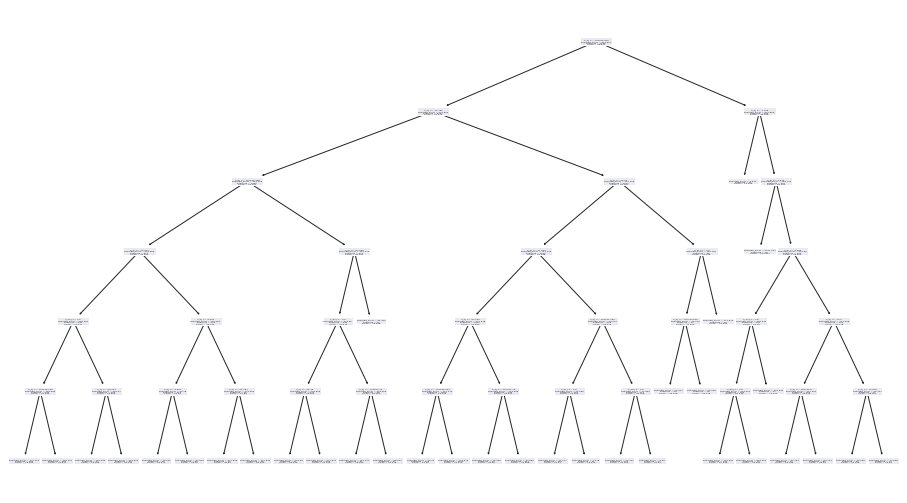

In [148]:
# wykres przedstawiający kolejne kroki drzewa decyzyjnego    
plt.figure(figsize=(16,9))
tree.plot_tree(tree_model_2)
plt.show()

In [149]:
# Przewidywany y na zbiorze treningowym i testowym
y_predict_train_model_tree2 = tree_model_2.predict(X2_train)
y_predict_test_model_tree2 = tree_model_2.predict(X2_test)

In [150]:
calculate_metrics("Drzewo decyzyjne 2",y_train,y_test,y_predict_train_model_tree2, y_predict_test_model_tree2)

Model        R2  MAE_train   MAE_test  MAPE_train [%]  \
0         Dummy Model  0.000000  13.247796  27.706997       89.082009   
1  Drzewo decyzyjne 1  0.528860   8.959954  29.514629       56.425110   
2  Drzewo decyzyjne 2  0.575438   8.603801  28.212487       56.292723   

   MAPE_test [%]  RMSE_train  RMSE_test  
0      55.914380   17.707826  35.447713  
1      59.303356   12.154589  38.130495  
2      51.179954   11.538136  37.731046

Metryki nieco poprawiły się jednak nadal nie są zadowalające.

#Random forest

Kolejnym modelem, który zastosowano jest random forest, czyli model łączący modele drzewa decyzyjnego. Z racji, że stanowi rozszerzenie pierwszego modelu, róznież nie wymaga standaryzacji danych.

In [151]:
from sklearn.model_selection import cross_val_score
random_forest = RandomForestRegressor(n_jobs=-1,max_features=0.33)
tscv = TimeSeriesSplit(n_splits=5).split(X2_train)
print(cross_val_score(random_forest, X2_train, y_train, cv=tscv))

[-2.28855704 -3.94884862 -0.11440981 -0.89463428 -0.14812639]


In [152]:
random_forest = RandomForestRegressor(n_jobs=-1,max_features=0.33)
tscv = TimeSeriesSplit(n_splits=5).split(X2_train)

params_rf = {'max_depth': [2, 3, 5, 10, 20, 25],
             'min_samples_leaf': [7,10, 25, 50],
             'n_estimators': [5,10,20,40, 60,80]} #the number of decision trees you will be running in the model/the number of trees in the forest.

rf_gridsearch = GridSearchCV(random_forest,
                             params_rf, 
                             scoring='neg_mean_absolute_error',
                             cv=tscv,
                             verbose=10, 
                             n_jobs=-1)
rf_gridsearch.fit(X2_train, y_train)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)

random_forest = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best hyperparameter: {'max_depth': 25, 'min_samples_leaf': 7, 'n_estimators': 10}


In [153]:
# Przewidywany y na zbiorze treningowym i testowym
y_predict_train_random_forest = random_forest.predict(X2_train)
y_predict_test_random_forest = random_forest.predict(X2_test)

In [154]:
calculate_metrics("Random Forest",y_train,y_test,y_predict_train_random_forest, y_predict_test_random_forest)

Model        R2  MAE_train   MAE_test  MAPE_train [%]  \
0         Dummy Model  0.000000  13.247796  27.706997       89.082009   
1  Drzewo decyzyjne 1  0.528860   8.959954  29.514629       56.425110   
2  Drzewo decyzyjne 2  0.575438   8.603801  28.212487       56.292723   
3       Random Forest  0.807336   5.432740  24.277524       31.591682   

   MAPE_test [%]  RMSE_train  RMSE_test  
0      55.914380   17.707826  35.447713  
1      59.303356   12.154589  38.130495  
2      51.179954   11.538136  37.731046  
3      49.370262    7.772590  31.692318

#Regresja wielomianowa

Zastosowano także model regresji wielomianowej, jednak w uwagi na to, że należy on do grupy modeli parametrycznych należało wykonać standaryzację danych. Wtandaryzację oraz przejście przez PolynomialFeatures i LinearRegression wykonano w pipelinie. Poprzez Gridsearch wykonano wybór najlepszego stopnia wielomianu.

In [155]:
polynomial_regression_pipeline = make_pipeline(StandardScaler(),PolynomialFeatures(),
                                               LinearRegression())
tscv = TimeSeriesSplit(n_splits=5).split(X2_train)

# Nasz model sprawdzi poniższe hiperparametry
params = {'polynomialfeatures__degree': [2, 3, 4]}

polynomial_regression_gridsearch = GridSearchCV(polynomial_regression_pipeline, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=tscv,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
polynomial_regression_gridsearch.fit(X2_train, y_train)
print('\nBest hyperparameter:', polynomial_regression_gridsearch.best_params_)

polynomial_regression_model= polynomial_regression_gridsearch.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START polynomialfeatures__degree=2................................
[CV 1/5; 1/3] END polynomialfeatures__degree=2;, score=-2191.623 total time=   0.1s
[CV 2/5; 1/3] START polynomialfeatures__degree=2................................
[CV 2/5; 1/3] END polynomialfeatures__degree=2;, score=-488.799 total time=   0.1s
[CV 3/5; 1/3] START polynomialfeatures__degree=2................................
[CV 3/5; 1/3] END polynomialfeatures__degree=2;, score=-282.877 total time=   0.2s
[CV 4/5; 1/3] START polynomialfeatures__degree=2................................
[CV 4/5; 1/3] END polynomialfeatures__degree=2;, score=-159.448 total time=   0.2s
[CV 5/5; 1/3] START polynomialfeatures__degree=2................................
[CV 5/5; 1/3] END polynomialfeatures__degree=2;, score=-462.276 total time=   0.2s
[CV 1/5; 2/3] START polynomialfeatures__degree=3................................
[CV 1/5; 2/3] END polynomialfeatures__

In [156]:
# Przewidywany y na zbiorze treningowym i testowym
y_predict_train_polynomial_regression = polynomial_regression_model.predict(X2_train)
y_predict_test_polynomial_regression = polynomial_regression_model.predict(X2_test)

In [157]:
calculate_metrics("Regresja wielomianowa 2 stopnia",y_train,y_test,y_predict_train_polynomial_regression, y_predict_test_polynomial_regression)

Model        R2  MAE_train   MAE_test  \
0                      Dummy Model  0.000000  13.247796  27.706997   
1               Drzewo decyzyjne 1  0.528860   8.959954  29.514629   
2               Drzewo decyzyjne 2  0.575438   8.603801  28.212487   
3                    Random Forest  0.807336   5.432740  24.277524   
4  Regresja wielomianowa 2 stopnia  0.333773  10.896267  19.659149   

   MAPE_train [%]  MAPE_test [%]  RMSE_train  RMSE_test  
0       89.082009      55.914380   17.707826  35.447713  
1       56.425110      59.303356   12.154589  38.130495  
2       56.292723      51.179954   11.538136  37.731046  
3       31.591682      49.370262    7.772590  31.692318  
4       62.891509      43.653100   14.453615  25.390872

#Ewaluacja - ocena modeli

In [158]:
metrics_dataframe

Model        R2  MAE_train   MAE_test  \
0                      Dummy Model  0.000000  13.247796  27.706997   
1               Drzewo decyzyjne 1  0.528860   8.959954  29.514629   
2               Drzewo decyzyjne 2  0.575438   8.603801  28.212487   
3                    Random Forest  0.807336   5.432740  24.277524   
4  Regresja wielomianowa 2 stopnia  0.333773  10.896267  19.659149   

   MAPE_train [%]  MAPE_test [%]  RMSE_train  RMSE_test  
0       89.082009      55.914380   17.707826  35.447713  
1       56.425110      59.303356   12.154589  38.130495  
2       56.292723      51.179954   11.538136  37.731046  
3       31.591682      49.370262    7.772590  31.692318  
4       62.891509      43.653100   14.453615  25.390872

Drzewo decyzyjne 2


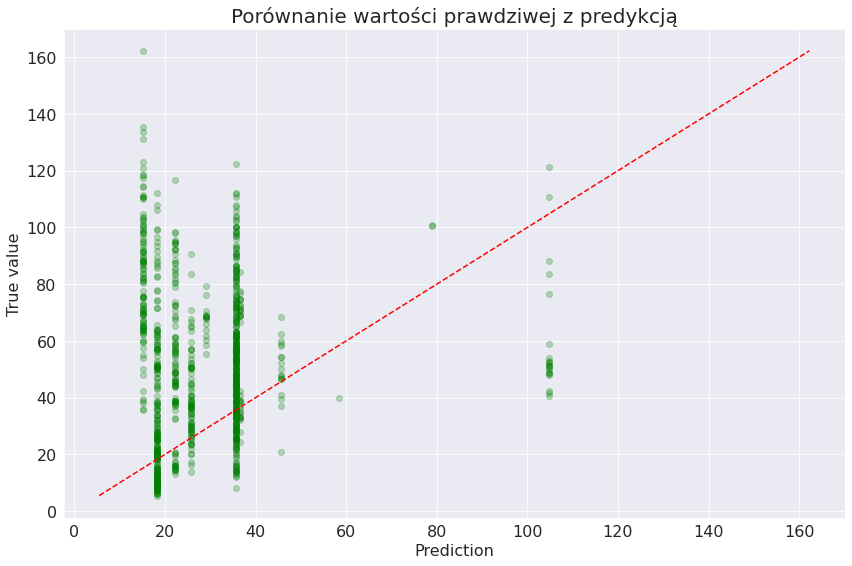

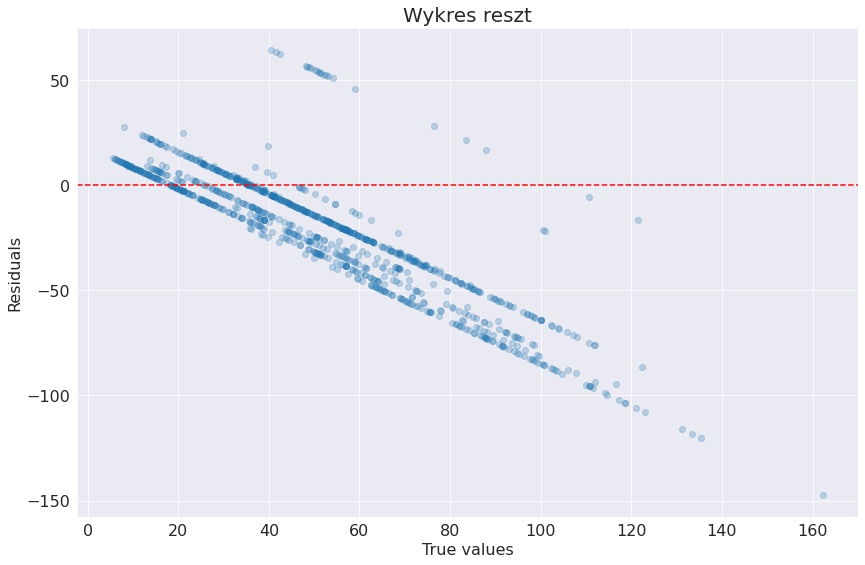

Średni błąd: -22.611676522375138


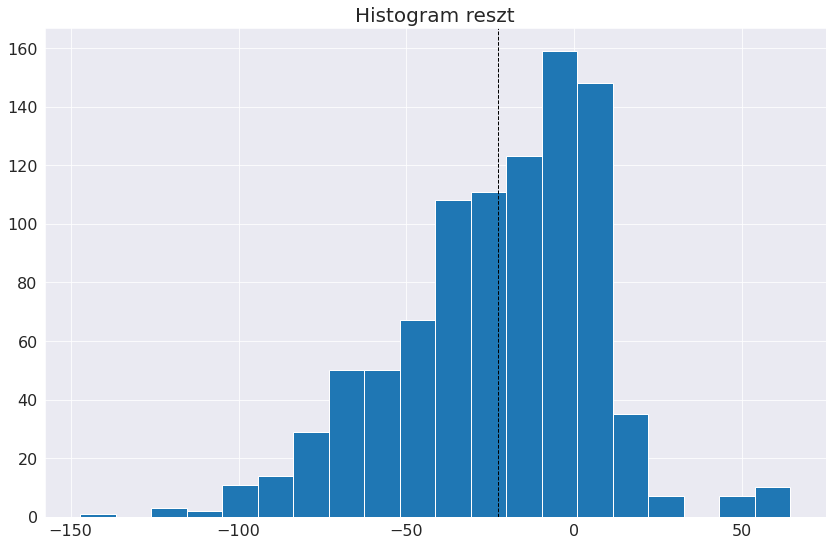

In [159]:
print('Drzewo decyzyjne 2')
plot_evaluation(y_predict_test_model_tree2,y_test)

Random forest


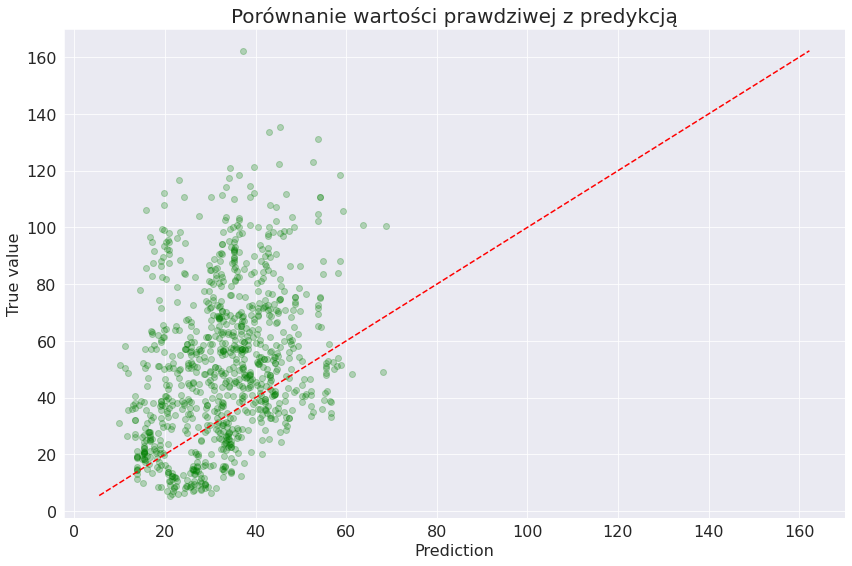

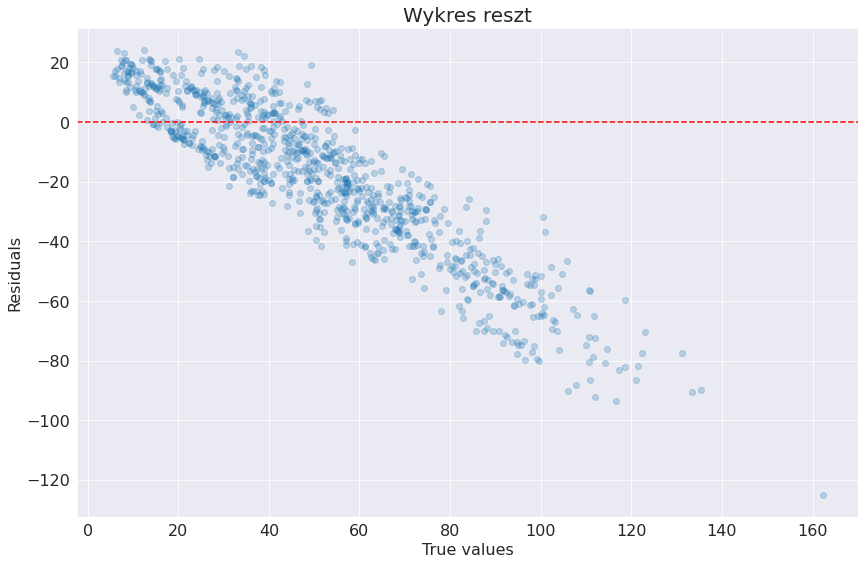

Średni błąd: -18.782527168007295


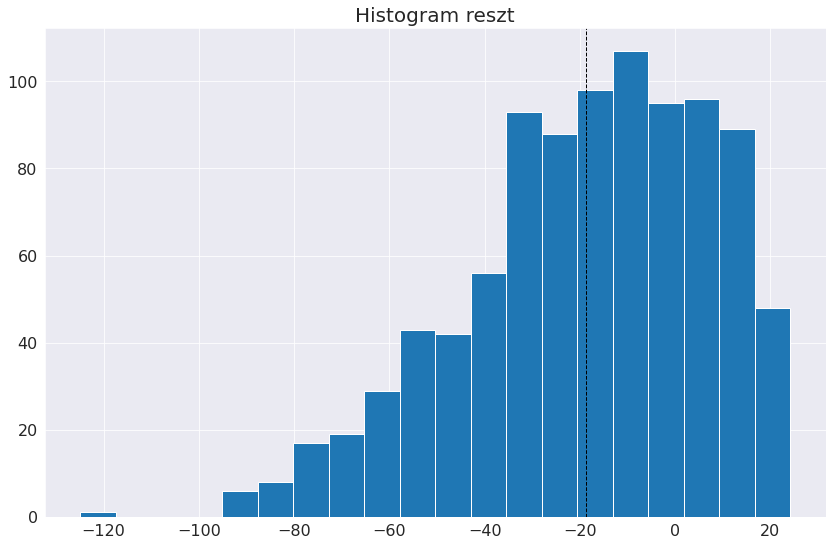

In [160]:
print('Random forest')
plot_evaluation(y_predict_test_random_forest,y_test)

Regresja wielomianowa


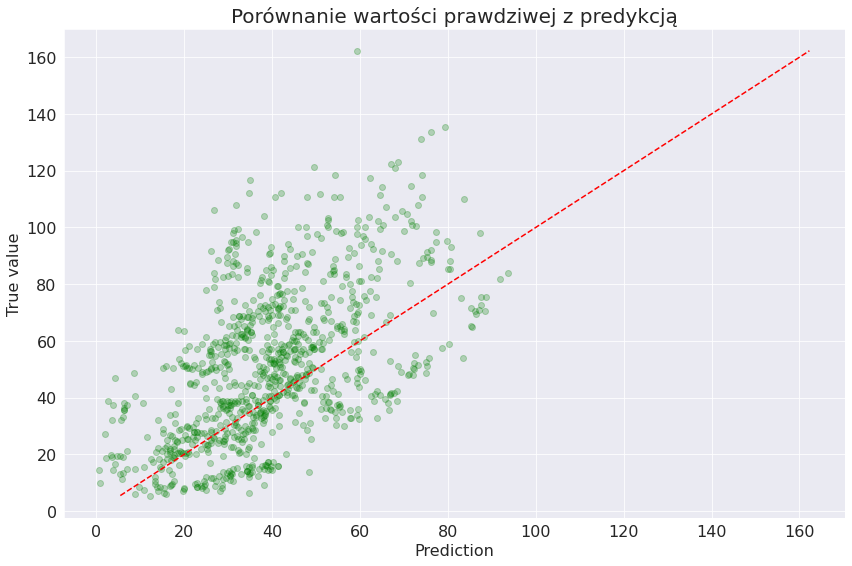

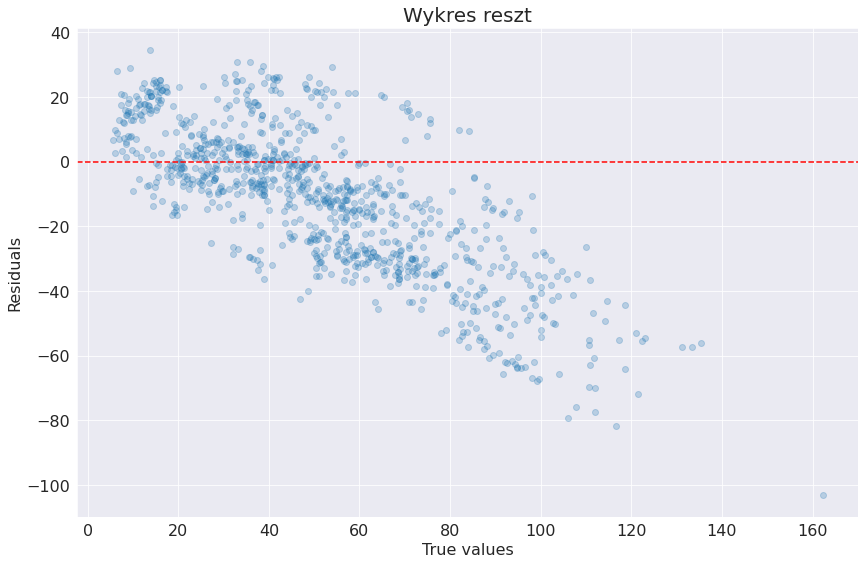

Średni błąd: -11.876813190545056


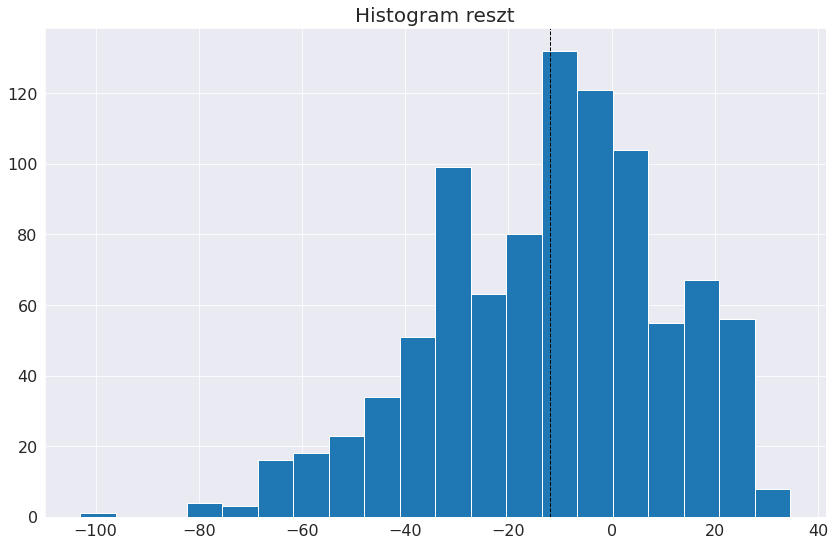

In [161]:
print('Regresja wielomianowa')
plot_evaluation(y_predict_test_polynomial_regression,y_test)

Otrzymując metryki dla wszystkich modeli oraz wykresy ewaluacyjne można wywnioskować, że najlepszym modelem jest model regresji wielomianowej. Mimo wszystko nie dokońa dobrze zostały wyjaśnione zależności pomiędzy danymi oraz wariancja co widać szczególnie na wykresie reszt, na którym nie powinno być widać żadnej zależności. W przypadku wszytkich modeli taka zależność jest widoczna.

Histogramy reszt w każdym przypadku są lewostronnie skośne co oznacza, że przeważają informacje wyższe niż średnia.

Aby rozwinąć problem, należałoby wrócić do etapu zrozumienia danych i uwzględnić dodatkowy czynnik. Prawdopodobnie duży wpływ na wskaźniki może mieć lokalizacja punktów pomiarowych.

#Zapisanie najlepszego modelu do pliku

In [162]:
polynomial_regression_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [163]:
import joblib
import pickle

finalized_model=polynomial_regression_model
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(finalized_model, open(filename, 'wb'))

In [164]:
import pickle
# load the model from disk
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
